# EDA для проекта поиска аномалий в сетевом трафике

> Пока решили использовать датасет CESNET вот тут коротко можно про него почитать

Постарался разбить ноутбук на какие то очевидные 

In [2]:
import pandas as pd
import numpy as np
import os
import json
import lzma
import glob
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import psutil
import gc

# скорее всего будем обрабатывать датасет параллельно, тк данных много
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from tqdm.notebook import tqdm

from scipy import stats
from scipy.stats import entropy

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [3]:
# на всякий пожарный вот такой класс для мониторинга памяти
# ранним все это дело в локальном jupyterlab на ПК с 32ГБ ОЗУ. Поэтому можем упасть
class MemoryMonitor:
    @staticmethod
    def get_memory_usage():
        return psutil.Process().memory_info().rss / 1024**3
    
    @staticmethod
    def print_memory_usage(prefix=""):
        usage = MemoryMonitor.get_memory_usage()
        available = psutil.virtual_memory().available / 1024**3
        print(f"{prefix} Memory: {usage:.2f}GB used, {available:.2f}GB available")
    
    @staticmethod
    def sizeof_fmt(num, suffix='B'):
        for unit in ['','Ki','Mi','Gi','Ti']:
            if abs(num) < 1024.0:
                return "%3.1f%s%s" % (num, unit, suffix)
            num /= 1024.0
        return "%.1f%s%s" % (num, 'Ti', suffix)

mem = MemoryMonitor()
mem.print_memory_usage("Initial")

Initial Memory: 0.24GB used, 18.15GB available


In [27]:
class CESNETDataLoader:
    def __init__(self, data_dir='../data'):
        """
        Класс для загрзки данных по датасету CESNET
        """
        self.data_dir = Path(data_dir)
        self.file_structure = {}
        self.stats = []
        
    def discover_structure(self):
        week_dirs = sorted(self.data_dir.glob('WEEK-*'))
        
        total_size = 0
        file_count = 0
        
        for week_dir in week_dirs:
            week_name = week_dir.name
            self.file_structure[week_name] = {}
            
            day_dirs = sorted(week_dir.glob('20*'))
            
            for day_dir in day_dirs:
                day_name = day_dir.name
                self.file_structure[week_name][day_name] = {
                    'flows': None,
                    'stats': None,
                    'size_compressed': 0,
                    'size_estimated': 0
                }
                
                csv_files = list(day_dir.glob('flows-*.csv.xz'))
                if csv_files:
                    csv_file = csv_files[0]
                    self.file_structure[week_name][day_name]['flows'] = csv_file
                    compressed_size = csv_file.stat().st_size
                    self.file_structure[week_name][day_name]['size_compressed'] = compressed_size
                    self.file_structure[week_name][day_name]['size_estimated'] = compressed_size * 7
                    total_size += compressed_size
                    file_count += 1
                stats_files = list(day_dir.glob('stats-*.json'))
                if stats_files:
                    self.file_structure[week_name][day_name]['stats'] = stats_files[0]
        
        print(f"Dataset structure:")
        print(f"  Weeks found: {len(self.file_structure)}")
        print(f"  Total CSV files: {file_count}")
        print(f"  Total compressed size: {mem.sizeof_fmt(total_size)}")
        print(f"  Estimated uncompressed: {mem.sizeof_fmt(total_size * 7)}")
        
        return self.file_structure
    
    def read_sample_file(self, nrows=10000):
        for week, days in self.file_structure.items():
            for day, files in days.items():
                if files['flows']:
                    print(f"Sampling from: {files['flows'].name}")
                    
                    with lzma.open(files['flows'], 'rt') as f:
                        header = f.readline()
                        print(f"Columns found: {len(header.split(','))}")
                        f.seek(0)
                        df = pd.read_csv(f, nrows=nrows)       
                    return df
        return None
    
    def load_single_file(self, filepath, columns=None, chunksize=None, nrows=None):
        if columns:
            with lzma.open(filepath, 'rt') as f:
                return pd.read_csv(f, usecols=columns, nrows=nrows, chunksize=chunksize)
        else:
            with lzma.open(filepath, 'rt') as f:
                return pd.read_csv(f, nrows=nrows, chunksize=chunksize)
    
    def optimize_dtypes(self, df):
        """
        Метод в который потом можно будет добавать какие то оптимизации для типов данных

        Upd пока хз насколько это полезно. Но данных много
        """
        initial_memory = df.memory_usage(deep=True).sum() / 1024**2
        
        for col in df.select_dtypes(include=['int']).columns:
            df[col] = pd.to_numeric(df[col], downcast='integer')
        
        for col in df.select_dtypes(include=['float']).columns:
            df[col] = pd.to_numeric(df[col], downcast='float')
        
        # Потом может пригодится возможность привести каста строк в категорию
        # for col in df.select_dtypes(include=['object']).columns:
        #     num_unique = df[col].nunique()
        #     num_total = len(df[col])
        #     if num_unique / num_total < 0.5:  # Less than 50% unique
        #         df[col] = df[col].astype('category')
        
        final_memory = df.memory_usage(deep=True).sum() / 1024**2
        print(f"Memory optimization: {initial_memory:.2f}MB -> {final_memory:.2f}MB ({(1-final_memory/initial_memory)*100:.1f}% reduction)")
        
        return df

# Initialize loader
loader = CESNETDataLoader('../data')
structure = loader.discover_structure()

Dataset structure:
  Weeks found: 7
  Total CSV files: 49
  Total compressed size: 3.6GiB
  Estimated uncompressed: 25.4GiB


Разбираемся со схемой данных

In [28]:
print("Loading sample data to understand structure...")
sample_df = loader.read_sample_file(nrows=10000)

print(f"\nDataset shape: {sample_df.shape}")
print(f"Memory usage: {sample_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn names and types:")
print(sample_df.dtypes)

print("\nFirst few rows:")
sample_df.head()

Loading sample data to understand structure...
Sampling from: flows-20221107.csv.xz
Columns found: 45

Dataset shape: (10000, 45)
Memory usage: 12.70 MB

Column names and types:
ID                         int64
SRC_IP                    object
DST_IP                    object
DST_ASN                    int64
DST_PORT                   int64
PROTOCOL                   int64
TLS_SNI                   object
TLS_JA3                   object
TIME_FIRST                object
TIME_LAST                 object
DURATION                 float64
BYTES                      int64
BYTES_REV                  int64
PACKETS                    int64
PACKETS_REV                int64
PPI_LEN                    int64
PPI_DURATION             float64
PPI_ROUNDTRIPS             int64
APP                       object
CATEGORY                  object
FLAG_CWR                   int64
FLAG_CWR_REV               int64
FLAG_ECE                   int64
FLAG_ECE_REV               int64
FLAG_URG                   int

,ID,SRC_IP,DST_IP,DST_ASN,DST_PORT,PROTOCOL,TLS_SNI,TLS_JA3,TIME_FIRST,TIME_LAST,DURATION,BYTES,BYTES_REV,PACKETS,PACKETS_REV,PPI_LEN,PPI_DURATION,PPI_ROUNDTRIPS,APP,CATEGORY,FLAG_CWR,FLAG_CWR_REV,FLAG_ECE,FLAG_ECE_REV,FLAG_URG,FLAG_URG_REV,FLAG_ACK,FLAG_ACK_REV,FLAG_PSH,FLAG_PSH_REV,FLAG_RST,FLAG_RST_REV,FLAG_SYN,FLAG_SYN_REV,FLAG_FIN,FLAG_FIN_REV,FLOW_ENDREASON_IDLE,FLOW_ENDREASON_ACTIVE,FLOW_ENDREASON_END,FLOW_ENDREASON_OTHER,PPI,PHIST_SRC_SIZES,PHIST_DST_SIZES,PHIST_SRC_IPT,PHIST_DST_IPT
0,443478893,224.181.203.81,2.22.89.45,20940,443,6,data.mistat.intl.xiaomi.com,d8c87b9bfde38897979e41242626c2f3,2022-11-06T22:00:00,2022-11-06T22:00:00.055359,0.055359,756,5313,11,8,6,0.029,1,xiaomi-tracking,Analytics & Telemetry,0,0,0,0,0,0,1,1,1,1,1,0,1,1,0,1,False,False,True,False,"[[0, 5, 0, 0, 13, 11], [1, -1, -1, -1, -1, 1],...","[1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 3]","[0, 1, 0, 0, 0, 0, 0, 0]","[3, 0, 0, 0, 0, 0, 0, 0]"
1,443478894,249.208.88.47,157.240.30.18,32934,443,6,graph.facebook.com,a5804cc8972df3ab8b7ccde6b7a9e0f4,2022-11-06T22:00:00,2022-11-06T22:00:00.193710,0.193710,2101,1563,8,7,6,0.146,3,facebook-graph,Other APIs,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,False,False,True,False,"[[0, 2, 21, 2, 11, 110], [1, -1, 1, -1, 1, -1]...","[0, 0, 0, 1, 0, 0, 1, 1]","[0, 0, 0, 0, 2, 0, 1, 0]","[1, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 0, 0, 0, 0]"
2,443478895,148.192.12.93,142.251.37.110,15169,443,6,suggestqueries-clients6.youtube.com,cd08e31494f9531f560d64c695473da9,2022-11-06T22:00:00,2022-11-06T22:01:00.448135,60.448135,1004,8146,10,10,9,45.044,2,youtube,Media,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,False,False,True,False,"[[0, 20, 0, 0, 0, 0, 9, 6, 45009], [1, -1, -1,...","[1, 0, 0, 1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 5]","[0, 1, 0, 0, 0, 0, 0, 1]","[5, 0, 0, 0, 0, 0, 0, 0]"
3,443478896,222.234.91.66,213.19.162.21,26667,443,6,fastlane.rubiconproject.com,04dd53033ee41ead468844c613c3baf2,2022-11-06T22:00:00,2022-11-06T22:00:19.792656,19.792656,6380,12745,19,30,26,4.757,5,rubiconproject,Advertising,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,False,False,True,False,"[[0, 13, 6, 15, 0, 1, 0, 0, 1, 0, 5, 0, 15, 63...","[0, 0, 0, 1, 0, 0, 2, 3]","[1, 0, 2, 4, 4, 3, 1, 6]","[1, 2, 0, 0, 0, 0, 1, 1]","[15, 2, 1, 0, 0, 0, 1, 1]"
4,443478897,251.160.54.204,146.112.61.106,36692,443,6,storage.live.com,a0e9f5d64349fb13191bc781f81f42e1,2022-11-06T22:00:00,2022-11-06T22:00:10.105111,10.105111,3323,4718,12,12,10,10.088,3,microsoft-onedrive,File sharing,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,False,False,True,False,"[[0, 7, 0, 5, 9, 22, 0, 8, 10003, 34], [1, -1,...","[0, 1, 0, 0, 1, 1, 1, 1]","[0, 1, 0, 0, 1, 1, 1, 2]","[2, 1, 0, 0, 0, 0, 0, 1]","[3, 1, 0, 0, 0, 0, 0, 1]"


In [29]:
class SmartDataLoader:
    """
    Надстройка над лоадером для датасета, с более умными лимитами по памяти
    """
    
    def __init__(self, loader, max_memory_gb=4):
        self.loader = loader
        self.max_memory_gb = max_memory_gb
        self.important_columns = None
        
    def identify_important_columns(self, sample_df):
        """
        Как идею можно потом использовать мето 
        """
        
        # columns_to_keep = []
        columns_metadata = {}
        
        for col in sample_df.columns:
            # Skip if too many missing values
            if sample_df[col].isnull().sum() / len(sample_df) > 0.9:
                continue
                
            # Check variance for numeric columns
            if sample_df[col].dtype in ['int64', 'float64']:
                if sample_df[col].std() > 0:  # Has variance
                    # columns_to_keep.append(col)
                    columns_metadata[col] = {
                        'type': 'numeric',
                        'variance': sample_df[col].std(),
                        'unique_ratio': sample_df[col].nunique() / len(sample_df)
                    }
            else:
                # For categorical, check cardinality
                unique_ratio = sample_df[col].nunique() / len(sample_df)
                if unique_ratio < 0.95:  # Not almost all unique
                    # columns_to_keep.append(col)
                    columns_metadata[col] = {
                        'type': 'categorical',
                        'cardinality': sample_df[col].nunique(),
                        'unique_ratio': unique_ratio
                    }
        
        # Essential network columns (always keep)
        # essential = ['sa', 'da', 'sp', 'dp', 'pr', 'flg', 'td', 'pkt', 'byt', 'label']
        # for col in essential:
        #     if col in sample_df.columns and col not in columns_to_keep:
        #         columns_to_keep.append(col)
        
        # self.important_columns = columns_to_keep
        # print(f"Selected {len(columns_to_keep)} / {len(sample_df.columns)} columns for analysis")
        print(f"Selected {len(sample_df.columns)} / {len(sample_df.columns)} columns for analysis")
        return sample_df.columns, columns_metadata
    
    def load_data_iteratively(self, max_files=None):
        """
        Load data file by file until memory limit is approached
        """
        dfs = []
        total_memory = 0
        files_loaded = 0
        
        available_memory = psutil.virtual_memory().available / 1024**3
        target_memory = min(self.max_memory_gb, available_memory * 0.5)  # Use max 50% of available
        
        print(f"Target memory usage: {target_memory:.2f}GB")
        
        for week, days in self.loader.file_structure.items():
            for day, files in days.items():
                if files['flows']:
                    if max_files and files_loaded >= max_files:
                        break
                    
                    # Estimate if we can load this file
                    estimated_size = files['size_estimated'] / 1024**3
                    if total_memory + estimated_size > target_memory:
                        print(f"Stopping: Next file would exceed memory limit")
                        break
                    
                    print(f"Loading {week}/{day}...", end=" ")
                    
                    try:
                        # Load with selected columns only
                        df = self.loader.load_single_file(
                            files['flows'], 
                            columns=self.important_columns,
                            nrows=None  # Load full file
                        )
                        
                        # Optimize memory
                        df = self.loader.optimize_dtypes(df)
                        
                        # Add temporal metadata
                        df['day'] = day
                        df['week'] = week
                        
                        dfs.append(df)
                        
                        current_memory = df.memory_usage(deep=True).sum() / 1024**3
                        total_memory += current_memory
                        files_loaded += 1
                        
                        print(f"✓ ({current_memory:.2f}GB, total: {total_memory:.2f}GB)")
                        
                    except Exception as e:
                        print(f"✗ Error: {e}")
                
                if max_files and files_loaded >= max_files:
                    break
            
            if total_memory > target_memory * 0.8:
                break
        
        if dfs:
            print(f"\nCombining {len(dfs)} dataframes...")
            combined_df = pd.concat(dfs, ignore_index=True)
            
            # Final memory optimization
            combined_df = self.loader.optimize_dtypes(combined_df)

            print(combined_df.head())
            
            print(f"Final dataset: {combined_df.shape}")
            print(f"Memory usage: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f}MB")
            
            return combined_df
        
        return None

smart_loader = SmartDataLoader(loader, max_memory_gb=5)

# First understand columns
columns, metadata = smart_loader.identify_important_columns(sample_df)

print("\nColumn importance analysis:")
for col, meta in list(metadata.items())[:10]:
    print(f"  {col}: {meta}")

Selected 45 / 45 columns for analysis

Column importance analysis:
  ID: {'type': 'numeric', 'variance': np.float64(2886.8956799071675), 'unique_ratio': 1.0}
  SRC_IP: {'type': 'categorical', 'cardinality': 3998, 'unique_ratio': 0.3998}
  DST_IP: {'type': 'categorical', 'cardinality': 1803, 'unique_ratio': 0.1803}
  DST_ASN: {'type': 'numeric', 'variance': np.float64(13564.172128701066), 'unique_ratio': 0.0071}
  TLS_SNI: {'type': 'categorical', 'cardinality': 1023, 'unique_ratio': 0.1023}
  TLS_JA3: {'type': 'categorical', 'cardinality': 433, 'unique_ratio': 0.0433}
  TIME_FIRST: {'type': 'categorical', 'cardinality': 2, 'unique_ratio': 0.0002}
  DURATION: {'type': 'numeric', 'variance': np.float64(58.198127664769935), 'unique_ratio': 0.9976}
  BYTES: {'type': 'numeric', 'variance': np.float64(48339.88293257526), 'unique_ratio': 0.4689}
  BYTES_REV: {'type': 'numeric', 'variance': np.float64(4037702.022124691), 'unique_ratio': 0.5831}


In [30]:
# Cell 6: Load Actual Data for Analysis
# Choose strategy based on available memory
available_mem = psutil.virtual_memory().available / 1024**3
print(f"Available memory: {available_mem:.2f}GB")

if available_mem > 8:
    print("Loading multiple days for comprehensive analysis...")
    df = smart_loader.load_data_iteratively(max_files=7)  # One week
else:
    print("Limited memory - loading fewer files...")
    df = smart_loader.load_data_iteratively(max_files=2)  # Two days

# Backup: If still too large, sample the data
if df is not None and df.memory_usage(deep=True).sum() / 1024**3 > available_mem * 0.5:
    print("Data too large, sampling 50%...")
    df = df.sample(frac=0.5, random_state=42)
    gc.collect()

mem.print_memory_usage("After loading")

Available memory: 13.23GB
Loading multiple days for comprehensive analysis...
Target memory usage: 5.00GB
Loading WEEK-2022-45/2022-11-07... Memory optimization: 2694.97MB -> 2358.61MB (12.5% reduction)
✓ (2.54GB, total: 2.54GB)
Loading WEEK-2022-45/2022-11-08... Memory optimization: 2671.75MB -> 2346.73MB (12.2% reduction)
✓ (2.53GB, total: 5.06GB)
Stopping: Next file would exceed memory limit

Combining 2 dataframes...
Memory optimization: 5194.38MB -> 5194.38MB (0.0% reduction)
          ID          SRC_IP          DST_IP  DST_ASN  DST_PORT  PROTOCOL  \
0  443478893  224.181.203.81      2.22.89.45    20940       443         6   
1  443478894   249.208.88.47   157.240.30.18    32934       443         6   
2  443478895   148.192.12.93  142.251.37.110    15169       443         6   
3  443478896   222.234.91.66   213.19.162.21    26667       443         6   
4  443478897  251.160.54.204  146.112.61.106    36692       443         6   

                               TLS_SNI             

In [31]:
# Cell 7: Data Quality Assessment
def comprehensive_quality_check(df):
    """Detailed data quality analysis"""
    
    print("=" * 60)
    print("DATA QUALITY REPORT")
    print("=" * 60)
    
    # 1. Missing values
    print("\n1. MISSING VALUES:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_pct
    }).sort_values('Percentage', ascending=False)
    
    print(missing_df[missing_df['Missing_Count'] > 0].head(10))
    
    # 2. Duplicates
    print("\n2. DUPLICATE ANALYSIS:")
    
    # Full duplicates
    full_duplicates = df.duplicated().sum()
    print(f"  Full row duplicates: {full_duplicates:,} ({full_duplicates/len(df)*100:.2f}%)")
    
    # Flow-level duplicates (network 5-tuple)
    if all(col in df.columns for col in ['sa', 'da', 'sp', 'dp', 'pr']):
        flow_duplicates = df.duplicated(subset=['sa', 'da', 'sp', 'dp', 'pr']).sum()
        print(f"  Flow-level duplicates: {flow_duplicates:,} ({flow_duplicates/len(df)*100:.2f}%)")
    
    # 3. Data type issues
    print("\n3. DATA TYPE OPTIMIZATION POTENTIAL:")
    
    for col in df.select_dtypes(include=['object']).columns[:5]:
        unique_ratio = df[col].nunique() / len(df)
        print(f"  {col}: {df[col].nunique()} unique values (ratio: {unique_ratio:.4f})")
        if unique_ratio < 0.5:
            print(f"    → Could be converted to category")
    
    # 4. Anomalous values
    print("\n4. ANOMALOUS VALUES:")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols[:10]:
        if col in df.columns:
            # Check for negative values where unexpected
            if col in ['pkt', 'byt', 'td']:  # packets, bytes, duration
                negative_count = (df[col] < 0).sum()
                if negative_count > 0:
                    print(f"  {col}: {negative_count} negative values!")
            
            # Check for extreme outliers
            if df[col].std() > 0:
                z_scores = np.abs(stats.zscore(df[col].dropna()))
                extreme_outliers = (z_scores > 5).sum()
                if extreme_outliers > 0:
                    print(f"  {col}: {extreme_outliers} extreme outliers (|z| > 5)")
    
    # 5. Temporal consistency
    if 'td' in df.columns:  # duration
        print("\n5. TEMPORAL CONSISTENCY:")
        print(f"  Duration range: {df['td'].min():.2f} - {df['td'].max():.2f}")
        
        # Check for impossible durations
        impossible_duration = ((df['td'] < 0) | (df['td'] > 86400)).sum()  # > 1 day
        if impossible_duration > 0:
            print(f"  {impossible_duration} flows with impossible duration")
    
    return missing_df

quality_report = comprehensive_quality_check(df)

DATA QUALITY REPORT

1. MISSING VALUES:
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []

2. DUPLICATE ANALYSIS:
  Full row duplicates: 0 (0.00%)

3. DATA TYPE OPTIMIZATION POTENTIAL:
  SRC_IP: 258217 unique values (ratio: 0.0614)
    → Could be converted to category
  DST_IP: 18901 unique values (ratio: 0.0045)
    → Could be converted to category
  TLS_SNI: 18688 unique values (ratio: 0.0044)
    → Could be converted to category
  TLS_JA3: 8193 unique values (ratio: 0.0019)
    → Could be converted to category
  TIME_FIRST: 49 unique values (ratio: 0.0000)
    → Could be converted to category

4. ANOMALOUS VALUES:
  DURATION: 8901 extreme outliers (|z| > 5)
  BYTES: 513 extreme outliers (|z| > 5)
  BYTES_REV: 944 extreme outliers (|z| > 5)
  PACKETS: 2449 extreme outliers (|z| > 5)
  PACKETS_REV: 1202 extreme outliers (|z| > 5)


In [11]:
print(quality_report)

                       Missing_Count  Percentage
ID                                 0         0.0
SRC_IP                             0         0.0
DST_IP                             0         0.0
DST_ASN                            0         0.0
TLS_SNI                            0         0.0
TLS_JA3                            0         0.0
TIME_FIRST                         0         0.0
DURATION                           0         0.0
BYTES                              0         0.0
BYTES_REV                          0         0.0
PACKETS                            0         0.0
PACKETS_REV                        0         0.0
PPI_LEN                            0         0.0
PPI_DURATION                       0         0.0
PPI_ROUNDTRIPS                     0         0.0
APP                                0         0.0
CATEGORY                           0         0.0
FLAG_CWR                           0         0.0
FLAG_CWR_REV                       0         0.0
FLAG_ECE            

In [32]:
def analyze_general_characteristics(df):
    """Comprehensive dataset overview for CESNET-TLS22"""
    
    print("=" * 60)
    print("DATASET OVERVIEW - CESNET-TLS22")
    print("=" * 60)
    
    print(f"\nShape: {df.shape[0]:,} flows × {df.shape[1]} columns")
    print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Temporal span
    if 'TIME_FIRST' in df.columns:
        df['TIME_FIRST'] = pd.to_datetime(df['TIME_FIRST'], format='mixed')
        df['TIME_LAST'] = pd.to_datetime(df['TIME_LAST'], format='mixed')
        print(f"\nTemporal coverage:")
        print(f"  Start: {df['TIME_FIRST'].min()}")
        print(f"  End: {df['TIME_LAST'].max()}")
        print(f"  Duration: {df['TIME_LAST'].max() - df['TIME_FIRST'].min()}")
    
    # Protocol distribution
    if 'PROTOCOL' in df.columns:
        print("\nProtocol Distribution:")
        protocol_map = {6: 'TCP', 17: 'UDP', 1: 'ICMP', 47: 'GRE', 50: 'ESP', 51: 'AH'}
        df['PROTOCOL_NAME'] = df['PROTOCOL'].map(protocol_map).fillna('Other')
        
        for proto, count in df['PROTOCOL_NAME'].value_counts().items():
            pct = count / len(df) * 100
            print(f"  {proto:8s}: {count:8,} ({pct:.2f}%)")
    
    # Application distribution (UNIQUE TO CESNET!)
    if 'APP' in df.columns:
        print("\nTop 15 Applications:")
        app_counts = df['APP'].value_counts().head(15)
        
        for app, count in app_counts.items():
            pct = count / len(df) * 100
            print(f"  {app:30s}: {count:7,} ({pct:5.2f}%)")
    
    # Category distribution (UNIQUE TO CESNET!)
    if 'CATEGORY' in df.columns:
        print("\nTraffic Categories:")
        cat_counts = df['CATEGORY'].value_counts()
        
        for cat, count in cat_counts.head(10).items():
            pct = count / len(df) * 100
            print(f"  {cat:25s}: {count:7,} ({pct:5.2f}%)")
    
    # TLS Coverage (CRITICAL for encrypted traffic analysis!)
    if 'TLS_SNI' in df.columns:
        tls_flows = df['TLS_SNI'].notna().sum()
        tls_pct = tls_flows / len(df) * 100
        print(f"TLS/HTTPS Traffic: {tls_flows:,} flows ({tls_pct:.2f}%)")
        
        if tls_flows > 0:
            print("\nTop 10 TLS SNI (Server Name Indication):")
            sni_counts = df['TLS_SNI'].value_counts().head(10)
            for sni, count in sni_counts.items():
                print(f"  {sni:40s}: {count:6,}")
    
    # Port distribution
    if 'DST_PORT' in df.columns:
        print("\nTop 10 Destination Ports:")
        port_counts = df['DST_PORT'].value_counts().head(10)
        
        well_known = {80: 'HTTP', 443: 'HTTPS', 22: 'SSH', 21: 'FTP', 
                     25: 'SMTP', 53: 'DNS', 3306: 'MySQL', 3389: 'RDP',
                     8080: 'HTTP-Alt', 8443: 'HTTPS-Alt'}
        
        for port, count in port_counts.items():
            service = well_known.get(port, '')
            pct = count / len(df) * 100
            print(f"  {port:5d} {service:10s}: {count:7,} ({pct:5.2f}%)")
    
    # Basic statistics for key numeric features
    print("\nKey Traffic Statistics:")
    key_features = ['BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION', 'PPI_ROUNDTRIPS']
    
    stats_data = []
    for col in key_features:
        if col in df.columns:
            stats_data.append([
                col,
                df[col].mean(),
                df[col].median(),
                df[col].std(),
                df[col].min(),
                df[col].max()
            ])
    
    stats_df = pd.DataFrame(stats_data, 
                           columns=['Feature', 'Mean', 'Median', 'Std', 'Min', 'Max'])
    print(stats_df.to_string(index=False))
    
    # Flow end reason analysis
    print("\nFlow End Reasons:")
    end_reasons = ['FLOW_ENDREASON_IDLE', 'FLOW_ENDREASON_ACTIVE', 
                  'FLOW_ENDREASON_END', 'FLOW_ENDREASON_OTHER']
    for reason in end_reasons:
        if reason in df.columns:
            count = df[reason].sum()
            pct = count / len(df) * 100
            print(f"  {reason.replace('FLOW_ENDREASON_', ''):8s}: {count:7,} ({pct:5.2f}%)")
    
    return df

df = analyze_general_characteristics(df)

DATASET OVERVIEW - CESNET-TLS22

Shape: 4,202,864 flows × 47 columns
Memory: 5194.38 MB

Temporal coverage:
  Start: 2022-11-06 22:00:00
  End: 2022-11-08 22:06:02.194672
  Duration: 2 days 00:06:02.194672

Protocol Distribution:
  TCP     : 4,202,864 (100.00%)

Top 15 Applications:
  office365                     : 195,811 ( 4.66%)
  tiktok                        : 183,100 ( 4.36%)
  microsoft-settings            : 131,735 ( 3.13%)
  google-ads                    : 131,621 ( 3.13%)
  microsoft-authentication      : 121,874 ( 2.90%)
  facebook-graph                : 117,883 ( 2.80%)
  outlook                       : 117,808 ( 2.80%)
  microsoft-diagnostic          : 105,800 ( 2.52%)
  seznam-media                  : 103,612 ( 2.47%)
  appnexus                      : 103,247 ( 2.46%)
  instagram                     : 103,036 ( 2.45%)
  google-www                    :  96,530 ( 2.30%)
  apple-itunes                  :  92,740 ( 2.21%)
  doh                           :  90,374 ( 2.15%)
  

TEMPORAL ANALYSIS
Temporal Statistics:
  Average flows/minute: 85772.73
  Peak minute: 2022-11-07 11:00:00 (164514 flows)
  Burst periods detected: 0


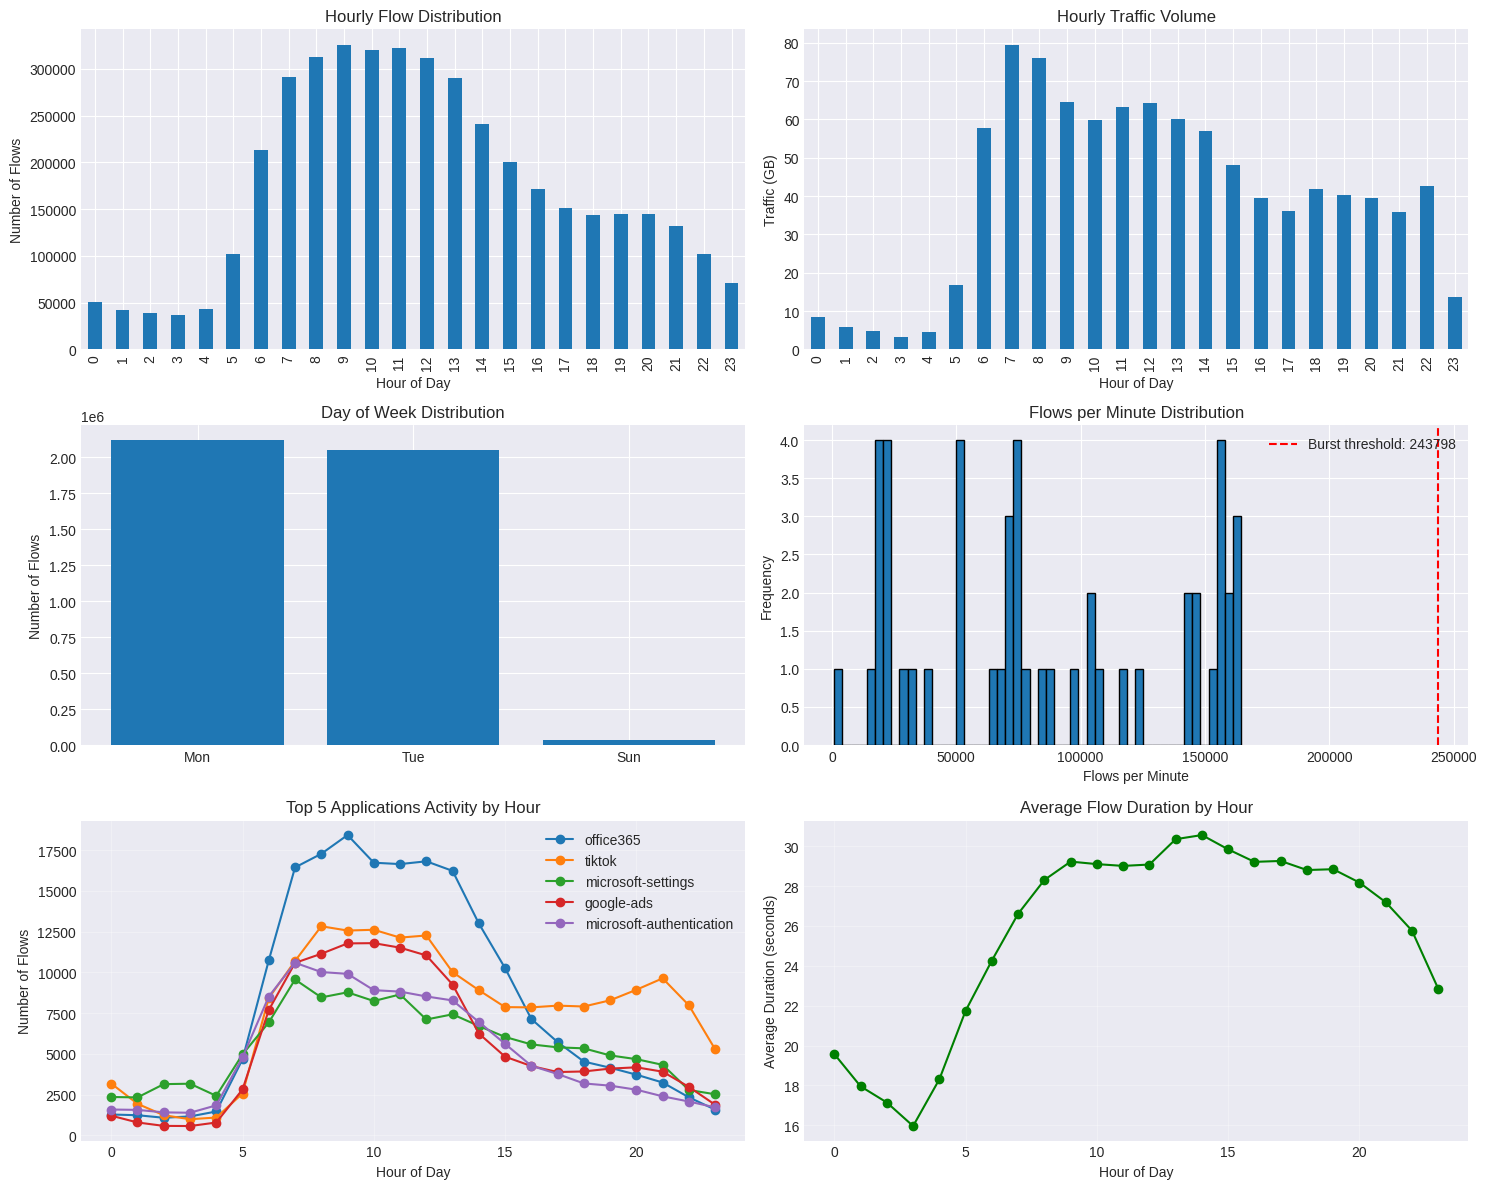


Temporal Patterns by Category:
  Advertising              : Peak at 11:00
  Social                   : Peak at 09:00
  Other services           : Peak at 09:00
  Media                    : Peak at 11:00
  Other APIs               : Peak at 09:00


In [33]:
# Cell 9: Temporal Analysis
def temporal_analysis(df):
    """Analyze temporal patterns in CESNET-TLS22 traffic"""
    
    print("=" * 60)
    print("TEMPORAL ANALYSIS")
    print("=" * 60)
    
    # Parse timestamps
    df['TIME_FIRST'] = pd.to_datetime(df['TIME_FIRST'])
    df['TIME_LAST'] = pd.to_datetime(df['TIME_LAST'])
    
    # Extract temporal features
    df['hour'] = df['TIME_FIRST'].dt.hour
    df['dayofweek'] = df['TIME_FIRST'].dt.dayofweek
    df['minute'] = df['TIME_FIRST'].dt.floor('T')
    
    # Connections per minute
    connections_per_minute = df.groupby('minute').size()
    
    # Burst detection
    burst_threshold = connections_per_minute.mean() + 3 * connections_per_minute.std()
    bursts = connections_per_minute[connections_per_minute > burst_threshold]
    
    print(f"Temporal Statistics:")
    print(f"  Average flows/minute: {connections_per_minute.mean():.2f}")
    print(f"  Peak minute: {connections_per_minute.idxmax()} ({connections_per_minute.max()} flows)")
    print(f"  Burst periods detected: {len(bursts)}")
    
    if len(bursts) > 0:
        print(f"  Max burst size: {bursts.max()} flows/minute")
    
    # Analyze traffic volume over time
    df['total_bytes'] = df['BYTES'] + df['BYTES_REV']
    
    # Hourly patterns
    hourly_stats = df.groupby('hour').agg({
        'ID': 'count',
        'total_bytes': 'sum',
        'DURATION': 'mean'
    }).rename(columns={'ID': 'flow_count'})
    
    # Create visualizations
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Hourly flow count
    hourly_stats['flow_count'].plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Hourly Flow Distribution')
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Number of Flows')
    
    # Hourly traffic volume
    (hourly_stats['total_bytes'] / 1024**3).plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('Hourly Traffic Volume')
    axes[0, 1].set_xlabel('Hour of Day')
    axes[0, 1].set_ylabel('Traffic (GB)')
    
    # Day of week patterns
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    dow_counts = df.groupby('dayofweek').size()
    axes[1, 0].bar(range(len(dow_counts)), dow_counts.values)
    axes[1, 0].set_xticks(range(len(dow_counts)))
    axes[1, 0].set_xticklabels([dow_names[i] for i in dow_counts.index])
    axes[1, 0].set_title('Day of Week Distribution')
    axes[1, 0].set_ylabel('Number of Flows')
    
    # Flows per minute histogram
    axes[1, 1].hist(connections_per_minute.values, bins=50, edgecolor='black')
    axes[1, 1].axvline(burst_threshold, color='r', linestyle='--', 
                       label=f'Burst threshold: {burst_threshold:.0f}')
    axes[1, 1].set_title('Flows per Minute Distribution')
    axes[1, 1].set_xlabel('Flows per Minute')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    
    # Application activity over time
    if 'APP' in df.columns:
        top_apps = df['APP'].value_counts().head(5).index
        for app in top_apps:
            app_hourly = df[df['APP'] == app].groupby('hour').size()
            axes[2, 0].plot(app_hourly.index, app_hourly.values, label=app, marker='o')
        
        axes[2, 0].set_title('Top 5 Applications Activity by Hour')
        axes[2, 0].set_xlabel('Hour of Day')
        axes[2, 0].set_ylabel('Number of Flows')
        axes[2, 0].legend(loc='best')
        axes[2, 0].grid(True, alpha=0.3)
    
    # Duration distribution over time
    hourly_duration = df.groupby('hour')['DURATION'].mean()
    axes[2, 1].plot(hourly_duration.index, hourly_duration.values, marker='o', color='green')
    axes[2, 1].set_title('Average Flow Duration by Hour')
    axes[2, 1].set_xlabel('Hour of Day')
    axes[2, 1].set_ylabel('Average Duration (seconds)')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze traffic patterns by category
    if 'CATEGORY' in df.columns:
        print("\nTemporal Patterns by Category:")
        top_categories = df['CATEGORY'].value_counts().head(5).index
        
        for cat in top_categories:
            cat_data = df[df['CATEGORY'] == cat]
            peak_hour = cat_data.groupby('hour').size().idxmax()
            print(f"  {cat:25s}: Peak at {peak_hour:02d}:00")
    
    return df

df = temporal_analysis(df)

FEATURE DISTRIBUTION ANALYSIS
Distribution Characteristics:
--------------------------------------------------

BYTES:
  Mean: 2.42e+04, Median: 2.32e+03
  Skewness: 596.300
  Kurtosis: 487848.565
Heavy-tailed distribution (kurtosis > 10)
Possible power-law distribution (R²: 0.748, α≈1.62)

BYTES_REV:
  Mean: 2.22e+05, Median: 6.07e+03
  Skewness: 958.436
  Kurtosis: 1036569.512
Heavy-tailed distribution (kurtosis > 10)
Possible power-law distribution (R²: 0.810, α≈2.00)

PACKETS:
  Mean: 8.30e+01, Median: 1.30e+01
  Skewness: 344.823
  Kurtosis: 187709.717
Heavy-tailed distribution (kurtosis > 10)
Possible power-law distribution (R²: 0.738, α≈1.36)

PACKETS_REV:
  Mean: 1.89e+02, Median: 1.20e+01
  Skewness: 937.820
  Kurtosis: 1006397.266
Heavy-tailed distribution (kurtosis > 10)
Possible power-law distribution (R²: 0.766, α≈1.64)

DURATION:
  Mean: 2.78e+01, Median: 2.23e+00
  Skewness: 3.288
  Kurtosis: 11.140
Heavy-tailed distribution (kurtosis > 10)
Possible power-law distributio

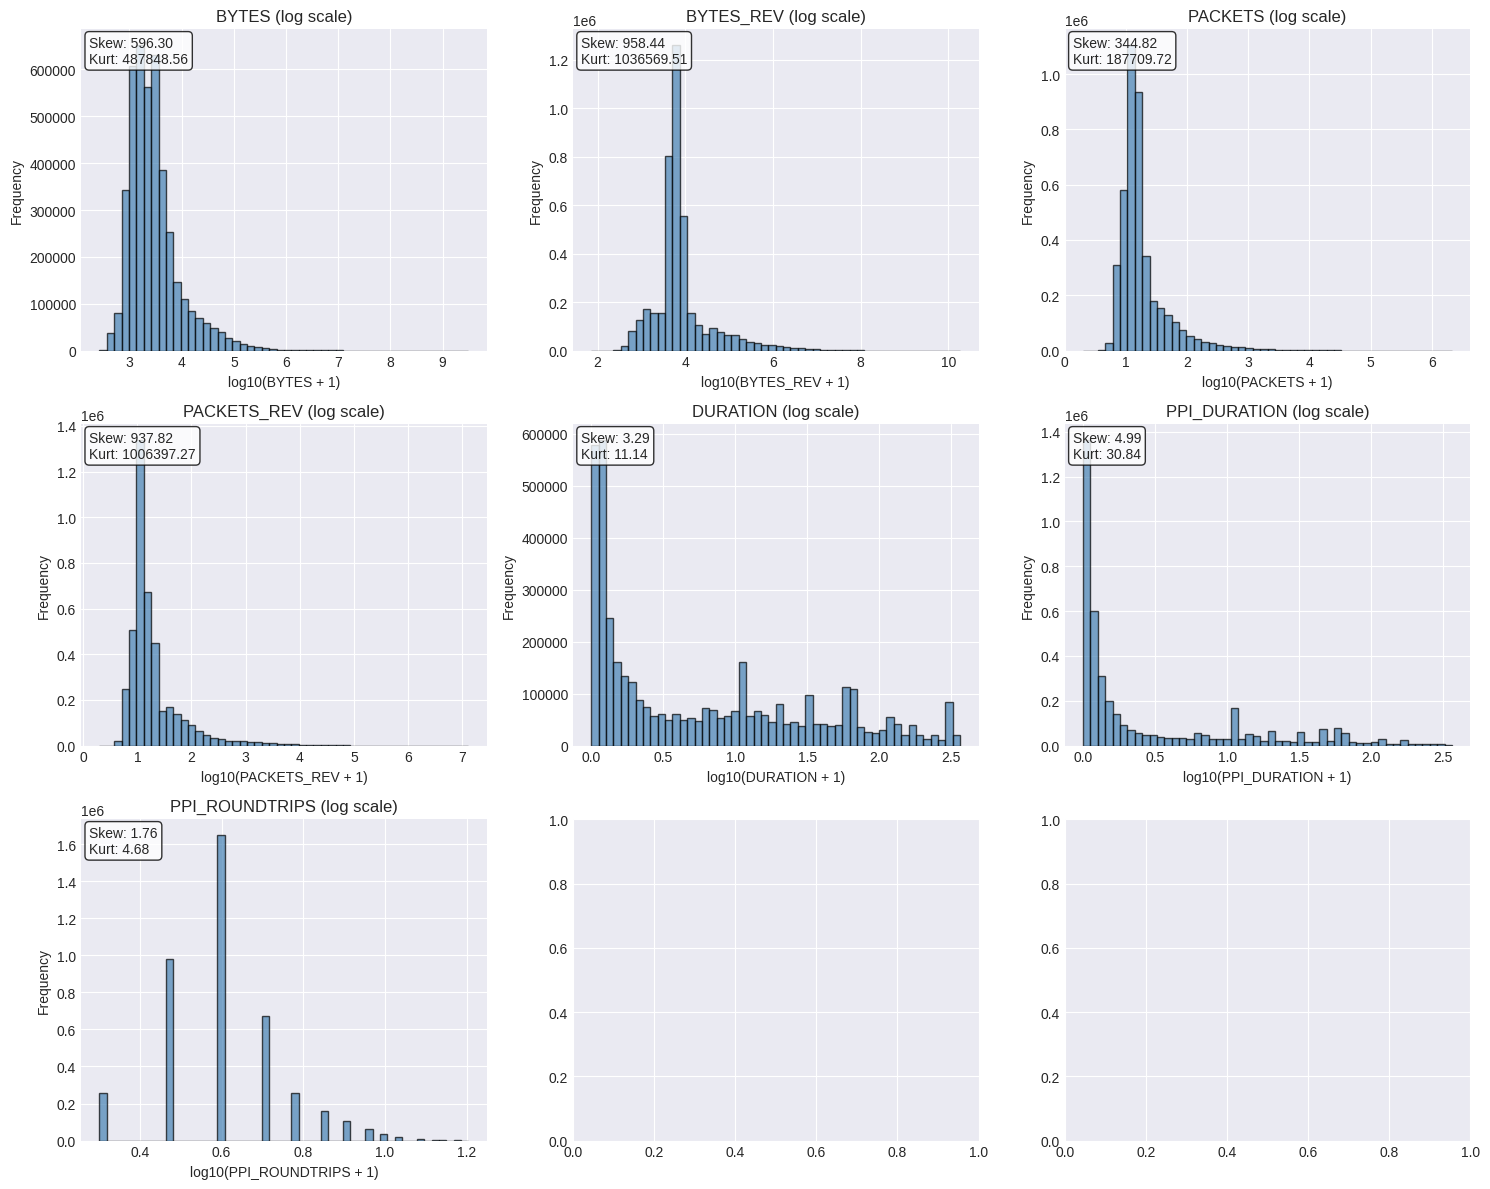


Bidirectional Traffic Analysis:
--------------------------------------------------
Bytes Forward/Total Ratio:
  Mean: 0.307
  Median: 0.263
  Highly asymmetric flows: 499,909 (11.89%)

Packets Forward/Total Ratio:
  Mean: 0.468
  Median: 0.480


In [35]:
# Cell 10: Feature Distribution Analysis
def analyze_feature_distributions(df):
    """Analyze distributions of CESNET-TLS22 features"""
    
    print("=" * 60)
    print("FEATURE DISTRIBUTION ANALYSIS")
    print("=" * 60)
    
    # Key network features
    key_features = ['BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 
                   'DURATION', 'PPI_DURATION', 'PPI_ROUNDTRIPS']
    available_features = [f for f in key_features if f in df.columns]
    
    # Statistical tests
    print("Distribution Characteristics:")
    print("-" * 50)
    
    for feature in available_features:
        data = df[feature].dropna()
        
        if len(data) > 100:
            print(f"\n{feature}:")
            print(f"  Mean: {data.mean():.2e}, Median: {data.median():.2e}")
            print(f"  Skewness: {data.skew():.3f}")
            print(f"  Kurtosis: {data.kurtosis():.3f}")
            
            # Heavy tail detection
            if data.kurtosis() > 10:
                print(f"Heavy-tailed distribution (kurtosis > 10)")
            
            # Check for power-law behavior
            if data.min() >= 0 and data.max() > 0:
                non_zero = data[data > 0]
                if len(non_zero) > 100:
                    # Fit power law using log-log regression
                    log_data = np.log10(non_zero)
                    percentiles = np.arange(1, 101)
                    sorted_log = np.sort(log_data)[::-1]
                    sample_points = sorted_log[::max(1, len(sorted_log)//100)][:100]
                    
                    if len(sample_points) > 10:
                        slope, intercept, r_value, _, _ = stats.linregress(
                            np.log10(percentiles[:len(sample_points)]), 
                            sample_points
                        )
                        if abs(r_value) > 0.8:
                            print(f"Possible power-law distribution (R²: {r_value**2:.3f}, α≈{-slope:.2f})")
    
    # Visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    plot_features = available_features[:9]
    
    for idx, feature in enumerate(plot_features):
        data = df[feature].dropna()
        
        # Log transform for better visualization
        log_data = np.log10(data[data > 0] + 1) if (data > 0).any() else data
        
        axes[idx].hist(log_data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[idx].set_title(f'{feature} (log scale)')
        axes[idx].set_xlabel(f'log10({feature} + 1)')
        axes[idx].set_ylabel('Frequency')
        
        # Add statistics annotation
        skew = data.skew()
        kurt = data.kurtosis()
        axes[idx].text(0.02, 0.98, 
                      f'Skew: {skew:.2f}\nKurt: {kurt:.2f}', 
                      transform=axes[idx].transAxes, 
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Analyze bidirectional traffic symmetry
    print("\nBidirectional Traffic Analysis:")
    print("-" * 50)
    
    if 'BYTES' in df.columns and 'BYTES_REV' in df.columns:
        df['bytes_ratio'] = df['BYTES'] / (df['BYTES'] + df['BYTES_REV'] + 1)
        
        print(f"Bytes Forward/Total Ratio:")
        print(f"  Mean: {df['bytes_ratio'].mean():.3f}")
        print(f"  Median: {df['bytes_ratio'].median():.3f}")
        
        # Identify asymmetric flows
        very_asymmetric = ((df['bytes_ratio'] < 0.1) | (df['bytes_ratio'] > 0.9)).sum()
        print(f"  Highly asymmetric flows: {very_asymmetric:,} ({very_asymmetric/len(df)*100:.2f}%)")
    
    if 'PACKETS' in df.columns and 'PACKETS_REV' in df.columns:
        df['packets_ratio'] = df['PACKETS'] / (df['PACKETS'] + df['PACKETS_REV'] + 1)
        
        print(f"\nPackets Forward/Total Ratio:")
        print(f"  Mean: {df['packets_ratio'].mean():.3f}")
        print(f"  Median: {df['packets_ratio'].median():.3f}")

analyze_feature_distributions(df)

TCP FLAGS AND APPLICATION ANALYSIS
TCP Flags Distribution (Forward Direction):
--------------------------------------------------
  CWR     : FWD: 236,117 ( 5.62%) | REV:   7,833 ( 0.19%)
  ECE     : FWD: 236,110 ( 5.62%) | REV: 145,978 ( 3.47%)
  URG     : FWD:       1 ( 0.00%) | REV:       0 ( 0.00%)
  ACK     : FWD: 4,202,751 (100.00%) | REV: 4,202,864 (100.00%)
  PSH     : FWD: 4,202,736 (100.00%) | REV: 4,202,193 (99.98%)
  RST     : FWD: 1,244,015 (29.60%) | REV: 452,955 (10.78%)
  SYN     : FWD: 4,201,423 (99.97%) | REV: 4,198,803 (99.90%)
  FIN     : FWD: 2,704,648 (64.35%) | REV: 2,783,992 (66.24%)

⚠️ Suspicious Flag Patterns:
  SYN-only flows: 113 (0.00%)
    Top apps: {'doh': 110, 'soundcloud': 3}
  Flows with RST: 1,578,781 (37.56%)
  Flows with URG: 1 (0.00%)

Application Behavior Profiles:
--------------------------------------------------
                     App  Count    Avg_Bytes  Avg_Duration  Avg_Packets  Port_443_%
               office365 195811 14942.070737     

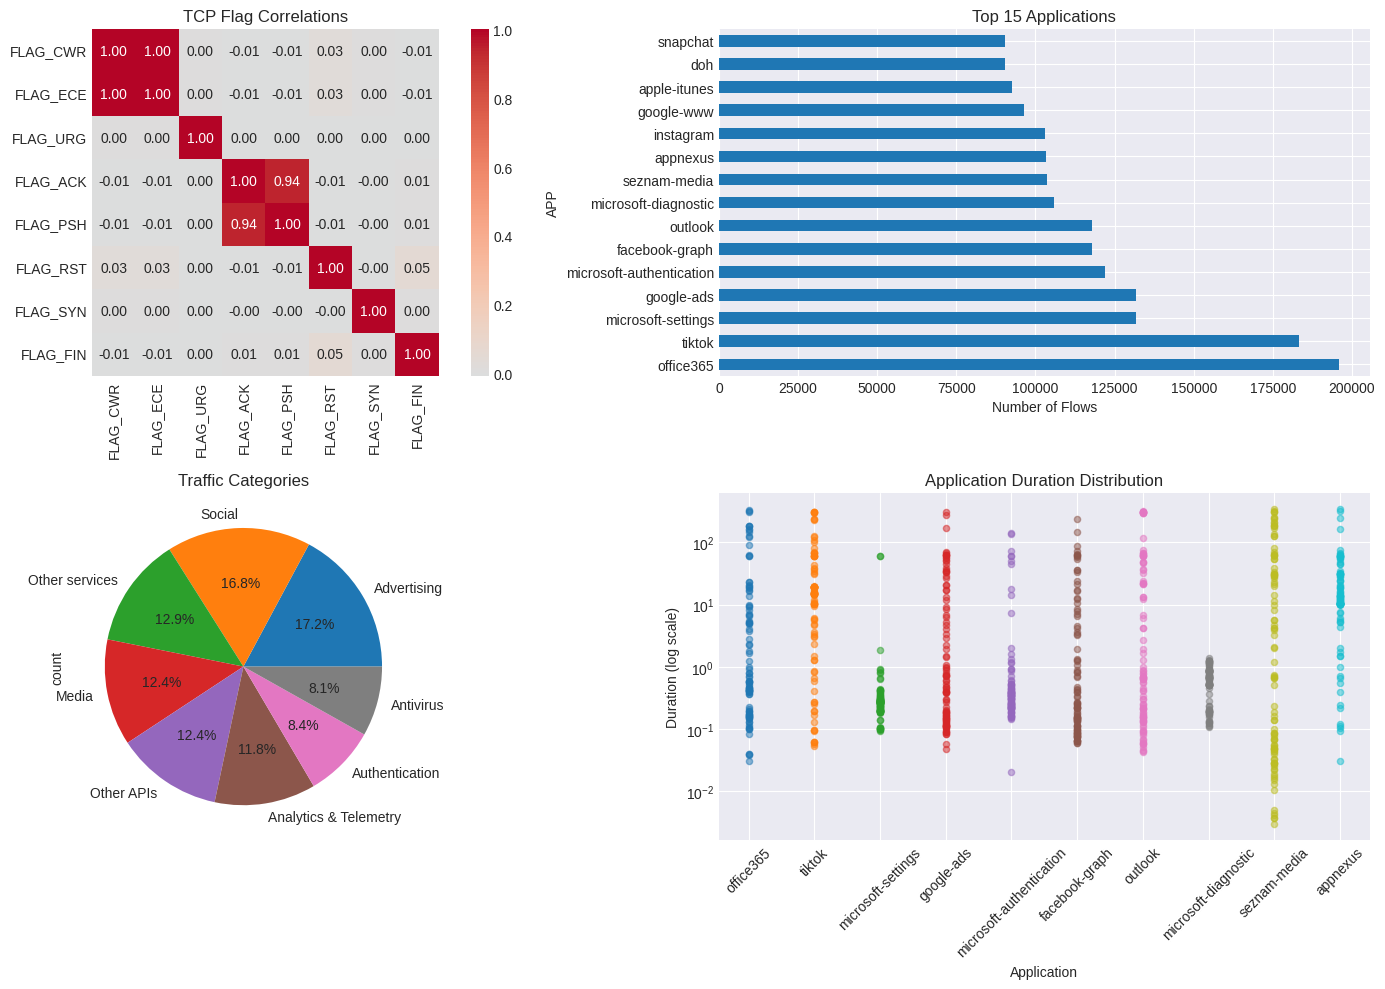

In [36]:
# Cell 11: TCP Flags and Application Analysis
def analyze_flags_and_apps(df):
    """Analyze TCP flags patterns and application behavior"""
    
    print("=" * 60)
    print("TCP FLAGS AND APPLICATION ANALYSIS")
    print("=" * 60)
    
    # TCP Flags analysis
    tcp_flags = ['FLAG_CWR', 'FLAG_ECE', 'FLAG_URG', 'FLAG_ACK', 
                'FLAG_PSH', 'FLAG_RST', 'FLAG_SYN', 'FLAG_FIN']
    
    print("TCP Flags Distribution (Forward Direction):")
    print("-" * 50)
    
    for flag in tcp_flags:
        if flag in df.columns:
            count = df[flag].sum()
            pct = count / len(df) * 100
            
            # Also check reverse direction
            flag_rev = flag + '_REV'
            if flag_rev in df.columns:
                count_rev = df[flag_rev].sum()
                pct_rev = count_rev / len(df) * 100
                print(f"  {flag.replace('FLAG_', ''):8s}: FWD: {count:7,} ({pct:5.2f}%) | REV: {count_rev:7,} ({pct_rev:5.2f}%)")
    
    # Detect suspicious flag patterns
    print("Suspicious Flag Patterns:")
    
    # SYN without ACK (potential SYN scan/flood)
    if 'FLAG_SYN' in df.columns and 'FLAG_ACK' in df.columns:
        syn_only = df[(df['FLAG_SYN'] == 1) & (df['FLAG_ACK'] == 0)]
        if len(syn_only) > 0:
            print(f"  SYN-only flows: {len(syn_only):,} ({len(syn_only)/len(df)*100:.2f}%)")
            if 'APP' in syn_only.columns:
                print(f"    Top apps: {syn_only['APP'].value_counts().head(3).to_dict()}")
    
    # RST flags (connection resets)
    if 'FLAG_RST' in df.columns:
        rst_flows = df[(df['FLAG_RST'] == 1) | (df['FLAG_RST_REV'] == 1)]
        if len(rst_flows) > 0:
            print(f"  Flows with RST: {len(rst_flows):,} ({len(rst_flows)/len(df)*100:.2f}%)")
    
    # URG flags (rarely used legitimately)
    if 'FLAG_URG' in df.columns:
        urg_flows = df[(df['FLAG_URG'] == 1) | (df['FLAG_URG_REV'] == 1)]
        if len(urg_flows) > 0:
            print(f"  Flows with URG: {len(urg_flows):,} ({len(urg_flows)/len(df)*100:.2f}%)")
    
    # Application behavior analysis
    if 'APP' in df.columns:
        print("\nApplication Behavior Profiles:")
        print("-" * 50)
        
        top_apps = df['APP'].value_counts().head(10).index
        
        app_profiles = []
        for app in top_apps:
            app_data = df[df['APP'] == app]
            
            profile = {
                'App': app,
                'Count': len(app_data),
                'Avg_Bytes': app_data['BYTES'].mean(),
                'Avg_Duration': app_data['DURATION'].mean(),
                'Avg_Packets': app_data['PACKETS'].mean(),
                'Port_443_%': (app_data['DST_PORT'] == 443).mean() * 100
            }
            app_profiles.append(profile)
        
        app_df = pd.DataFrame(app_profiles)
        print(app_df.to_string(index=False))
    
    # Category analysis
    if 'CATEGORY' in df.columns:
        print("\nTraffic Category Characteristics:")
        print("-" * 50)
        
        top_categories = df['CATEGORY'].value_counts().head(5).index
        
        for cat in top_categories:
            cat_data = df[df['CATEGORY'] == cat]
            print(f"\n{cat}:")
            print(f"  Flows: {len(cat_data):,}")
            print(f"  Avg Duration: {cat_data['DURATION'].mean():.2f}s")
            print(f"  Avg Bytes: {cat_data['BYTES'].mean():.0f}")
            
            # Top apps in category
            if 'APP' in cat_data.columns:
                top_apps_in_cat = cat_data['APP'].value_counts().head(3)
                print(f"  Top Apps: {', '.join([f'{app}({cnt})' for app, cnt in top_apps_in_cat.items()])}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Flag combinations heatmap
    if all(flag in df.columns for flag in tcp_flags):
        flag_data = df[tcp_flags].astype(int)
        flag_corr = flag_data.corr()
        
        sns.heatmap(flag_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, square=True, ax=axes[0, 0])
        axes[0, 0].set_title('TCP Flag Correlations')
    
    # Top applications bar chart
    if 'APP' in df.columns:
        df['APP'].value_counts().head(15).plot(kind='barh', ax=axes[0, 1])
        axes[0, 1].set_title('Top 15 Applications')
        axes[0, 1].set_xlabel('Number of Flows')
    
    # Category pie chart
    if 'CATEGORY' in df.columns:
        df['CATEGORY'].value_counts().head(8).plot(kind='pie', autopct='%1.1f%%', ax=axes[1, 0])
        axes[1, 0].set_title('Traffic Categories')
    
    # Application vs Duration scatter
    if 'APP' in df.columns and 'DURATION' in df.columns:
        top_apps_for_plot = df['APP'].value_counts().head(10).index
        
        for app in top_apps_for_plot:
            app_data = df[df['APP'] == app]['DURATION'].values[:100]  # Sample for visibility
            axes[1, 1].scatter([app]*len(app_data), app_data, alpha=0.5, s=20)
        
        axes[1, 1].set_yscale('log')
        axes[1, 1].set_xlabel('Application')
        axes[1, 1].set_ylabel('Duration (log scale)')
        axes[1, 1].set_title('Application Duration Distribution')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

analyze_flags_and_apps(df)

TLS/HTTPS ENCRYPTED TRAFFIC ANALYSIS
TLS Statistics:
  Total TLS flows: 4,202,864 (100.00%)
  Flows with SNI: 4,202,864 (100.00%)

Top 20 TLS Server Names (SNI):
  settings-win.data.microsoft.com               (microsoft.com  ): 131,724 ( 3.13%)
  graph.facebook.com                            (facebook.com   ): 117,883 ( 2.80%)
  v10.events.data.microsoft.com                 (microsoft.com  ): 98,101 ( 2.33%)
  outlook.office365.com                         (office365.com  ): 98,020 ( 2.33%)
  login.microsoftonline.com                     (microsoftonline.com): 83,292 ( 1.98%)
  www.google.com                                (google.com     ): 83,109 ( 1.98%)
  www.bing.com                                  (bing.com       ): 63,948 ( 1.52%)
  doh.opendns.com                               (opendns.com    ): 51,692 ( 1.23%)
  client.wns.windows.com                        (windows.com    ): 43,655 ( 1.04%)
  storage.live.com                              (live.com       ): 43,057 ( 1.02%)
  

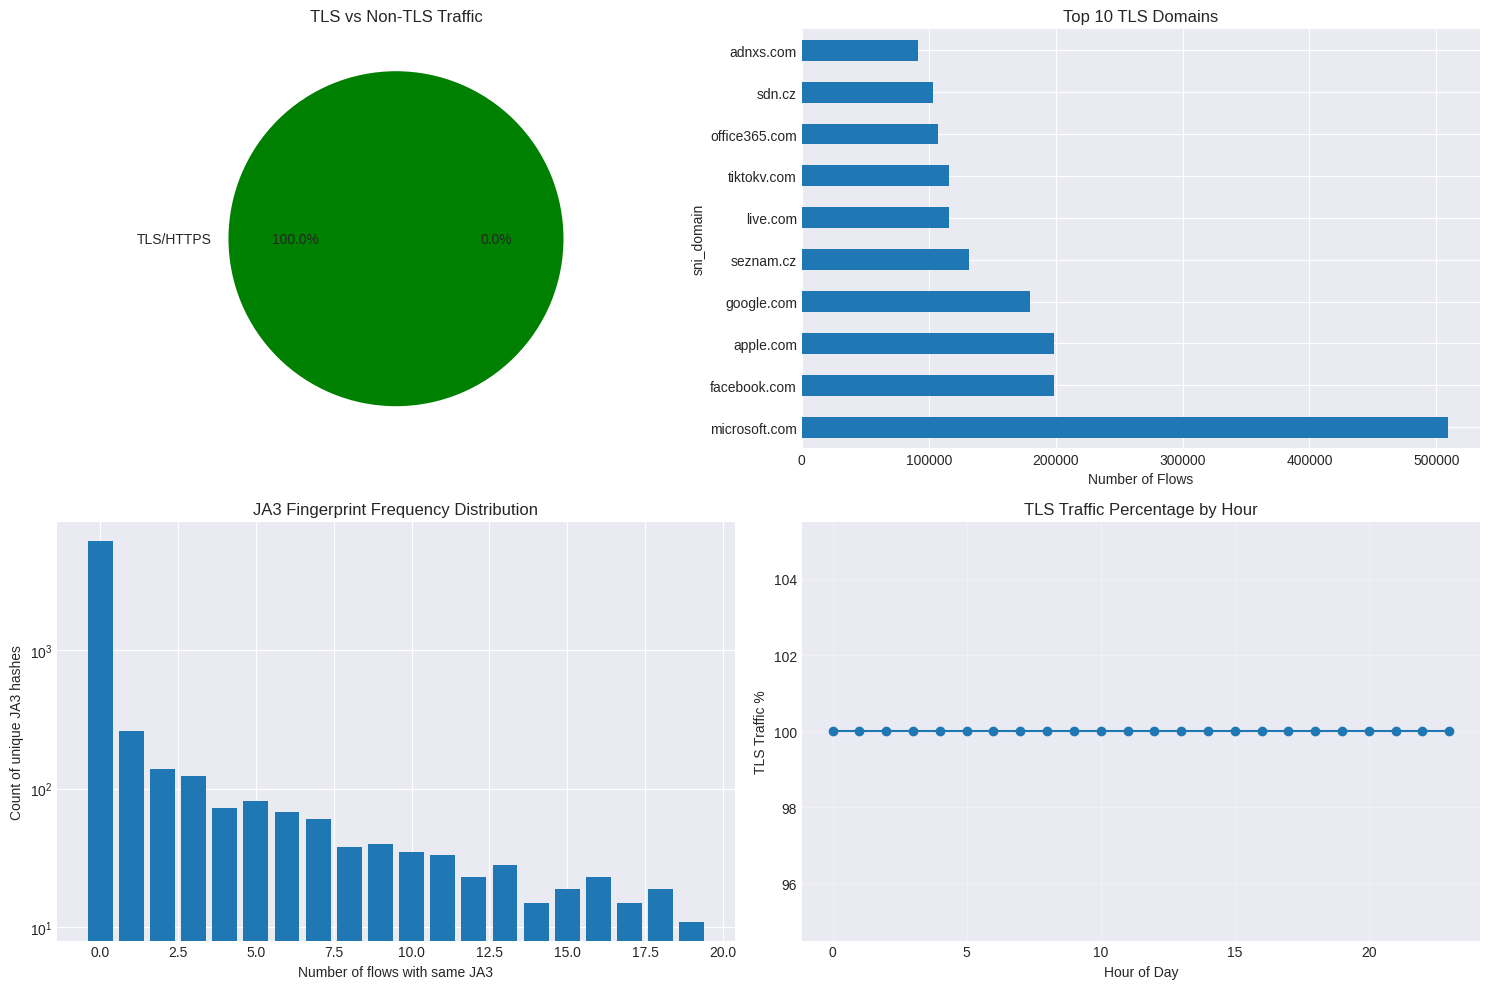

In [37]:
# Cell 12: TLS Analysis (UNIQUE TO CESNET!)
def analyze_tls_patterns(df):
    """Analyze TLS/HTTPS encrypted traffic patterns"""
    
    print("=" * 60)
    print("TLS/HTTPS ENCRYPTED TRAFFIC ANALYSIS")
    print("=" * 60)
    
    # TLS coverage
    tls_mask = df['TLS_SNI'].notna() | df['TLS_JA3'].notna()
    tls_flows = tls_mask.sum()
    tls_pct = tls_flows / len(df) * 100
    
    print(f"TLS Statistics:")
    print(f"  Total TLS flows: {tls_flows:,} ({tls_pct:.2f}%)")
    
    # SNI Analysis
    if 'TLS_SNI' in df.columns:
        sni_coverage = df['TLS_SNI'].notna().sum()
        print(f"  Flows with SNI: {sni_coverage:,} ({sni_coverage/len(df)*100:.2f}%)")
        
        # Top SNI domains
        print("\nTop 20 TLS Server Names (SNI):")
        sni_counts = df['TLS_SNI'].value_counts().head(20)
        
        for sni, count in sni_counts.items():
            pct = count / sni_coverage * 100
            # Extract domain
            domain = sni.split('.')[-2:] if '.' in str(sni) else str(sni)
            domain = '.'.join(domain) if isinstance(domain, list) else domain
            print(f"  {sni:45s} ({domain:15s}): {count:6,} ({pct:5.2f}%)")
    
    # JA3 Fingerprint Analysis
    if 'TLS_JA3' in df.columns:
        ja3_coverage = df['TLS_JA3'].notna().sum()
        unique_ja3 = df['TLS_JA3'].nunique()
        
        print(f"\nJA3 TLS Fingerprinting:")
        print(f"  Flows with JA3: {ja3_coverage:,}")
        print(f"  Unique JA3 hashes: {unique_ja3:,}")
        print(f"  JA3 diversity ratio: {unique_ja3/ja3_coverage:.4f}")
        
        # Top JA3 fingerprints
        print("\nTop 10 JA3 Fingerprints (Client Hello patterns):")
        ja3_counts = df['TLS_JA3'].value_counts().head(10)
        
        for ja3, count in ja3_counts.items():
            pct = count / ja3_coverage * 100
            print(f"  {ja3}: {count:6,} ({pct:5.2f}%)")
            
            # Check associated applications
            if 'APP' in df.columns:
                top_app = df[df['TLS_JA3'] == ja3]['APP'].value_counts().head(1)
                if not top_app.empty:
                    print(f"    → Most common app: {top_app.index[0]}")
    
    # TLS vs Non-TLS comparison
    print("\nTLS vs Non-TLS Traffic Comparison:")
    
    tls_df = df[tls_mask]
    non_tls_df = df[~tls_mask]
    
    comparison = pd.DataFrame({
        'Metric': ['Avg Duration (s)', 'Avg Bytes', 'Avg Packets', 'Avg Roundtrips'],
        'TLS': [
            tls_df['DURATION'].mean() if len(tls_df) > 0 else 0,
            tls_df['BYTES'].mean() if len(tls_df) > 0 else 0,
            tls_df['PACKETS'].mean() if len(tls_df) > 0 else 0,
            tls_df['PPI_ROUNDTRIPS'].mean() if len(tls_df) > 0 else 0
        ],
        'Non-TLS': [
            non_tls_df['DURATION'].mean() if len(non_tls_df) > 0 else 0,
            non_tls_df['BYTES'].mean() if len(non_tls_df) > 0 else 0,
            non_tls_df['PACKETS'].mean() if len(non_tls_df) > 0 else 0,
            non_tls_df['PPI_ROUNDTRIPS'].mean() if len(non_tls_df) > 0 else 0
        ]
    })
    
    comparison['Ratio'] = comparison['TLS'] / (comparison['Non-TLS'] + 0.001)
    print(comparison.to_string(index=False))
    
    # Port 443 analysis
    if 'DST_PORT' in df.columns:
        port_443 = df[df['DST_PORT'] == 443]
        port_443_tls = port_443[port_443['TLS_SNI'].notna()]
        
        print(f"\nPort 443 (HTTPS) Analysis:")
        print(f"  Total flows on 443: {len(port_443):,}")
        print(f"  With TLS SNI: {len(port_443_tls):,} ({len(port_443_tls)/len(port_443)*100:.2f}%)")
        
        # Non-standard HTTPS
        tls_non_443 = df[(df['TLS_SNI'].notna()) & (df['DST_PORT'] != 443)]
        if len(tls_non_443) > 0:
            print(f"TLS on non-standard ports: {len(tls_non_443):,}")
            unusual_ports = tls_non_443['DST_PORT'].value_counts().head(10)
            print("  Top non-443 TLS ports:")
            for port, count in unusual_ports.items():
                print(f"    Port {port}: {count:,} flows")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # TLS vs Non-TLS pie chart
    tls_dist = pd.Series({'TLS/HTTPS': tls_flows, 'Non-TLS': len(df) - tls_flows})
    tls_dist.plot(kind='pie', autopct='%1.1f%%', ax=axes[0, 0], colors=['green', 'gray'])
    axes[0, 0].set_title('TLS vs Non-TLS Traffic')
    
    # Top SNI domains
    if 'TLS_SNI' in df.columns:
        # Extract base domains
        df['sni_domain'] = df['TLS_SNI'].apply(
            lambda x: '.'.join(str(x).split('.')[-2:]) if pd.notna(x) and '.' in str(x) else x
        )
        domain_counts = df['sni_domain'].value_counts().head(10)
        domain_counts.plot(kind='barh', ax=axes[0, 1])
        axes[0, 1].set_title('Top 10 TLS Domains')
        axes[0, 1].set_xlabel('Number of Flows')
    
    # JA3 diversity
    if 'TLS_JA3' in df.columns:
        ja3_counts = df['TLS_JA3'].value_counts()
        ja3_freq_dist = ja3_counts.value_counts().sort_index()
        
        axes[1, 0].bar(range(min(20, len(ja3_freq_dist))), 
                      ja3_freq_dist.values[:20])
        axes[1, 0].set_xlabel('Number of flows with same JA3')
        axes[1, 0].set_ylabel('Count of unique JA3 hashes')
        axes[1, 0].set_title('JA3 Fingerprint Frequency Distribution')
        axes[1, 0].set_yscale('log')
    
    # TLS traffic over time
    if 'TIME_FIRST' in df.columns:
        df['hour'] = pd.to_datetime(df['TIME_FIRST']).dt.hour
        hourly_tls = df[tls_mask].groupby('hour').size()
        hourly_total = df.groupby('hour').size()
        hourly_tls_pct = (hourly_tls / hourly_total * 100).fillna(0)
        
        axes[1, 1].plot(hourly_tls_pct.index, hourly_tls_pct.values, marker='o')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('TLS Traffic %')
        axes[1, 1].set_title('TLS Traffic Percentage by Hour')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df

df = analyze_tls_patterns(df)

SESSION ANALYSIS
Creating session identifiers...
Session Statistics:
  Total unique sessions: 1,497,387
  Flows per session: 2.81 (avg), 58166 (max)
  Bytes per session: 690644 (avg)
  Duration per session: 78.04s (avg)

Multi-flow sessions: 385,570 (25.75%)
Long sessions (>1h): 1,964
Top 5 Long Sessions:
  251.160.54.204 → 146.112.61.106:443
    Duration: 121.4h, App: microsoft-onedrive, Flows: 58166
  56.235.102.215 → 146.112.41.2:443
    Duration: 38.8h, App: doh, Flows: 10073
  250.250.126.255 → 146.112.41.2:443
    Duration: 32.9h, App: doh, Flows: 8316
  54.109.106.43 → 146.112.41.2:443
    Duration: 28.9h, App: doh, Flows: 7800
  251.160.54.204 → 52.113.194.132:443
    Duration: 24.8h, App: teams, Flows: 1544

Top 10 Sessions by Volume:
  d427:6e85:209e:2a4c:325f:a96a:cde:6859 → 2001:718:ff03:400::1:102:443
    55856.36 MB, 41142692 packets, 5 flows
    App: cesnet-filesender, Category: File sharing
  12.13.101.246 → 8.253.95.117:443
    4015.91 MB, 4489198 packets, 2 flows
    

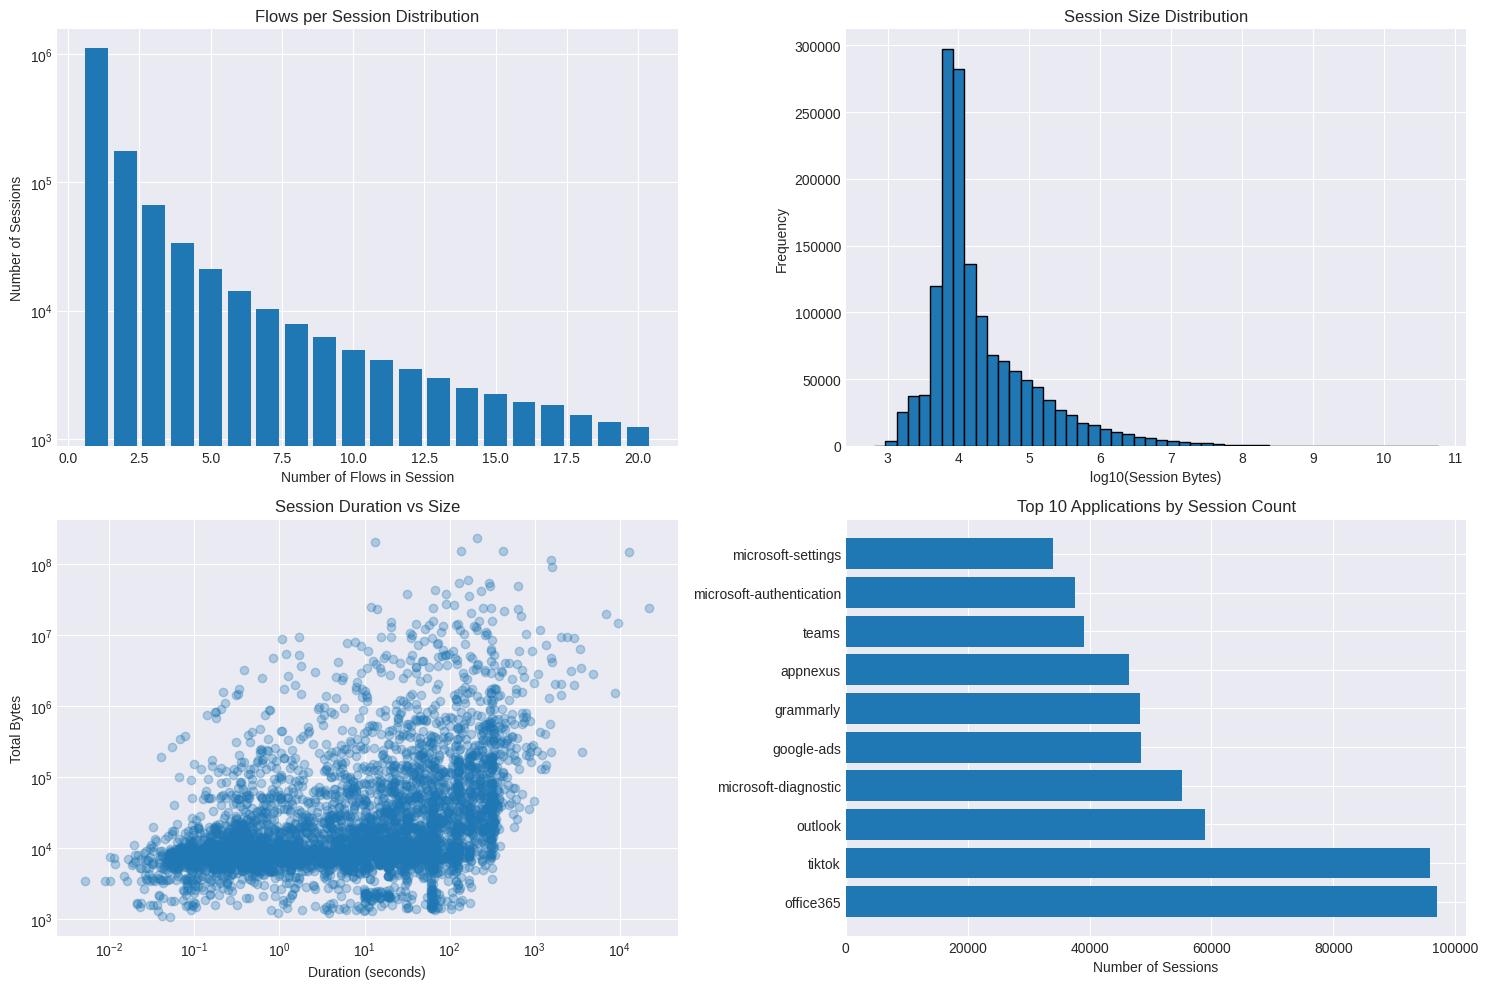

In [41]:
def session_analysis(df):
    """Reconstruct and analyze network sessions"""
    
    print("=" * 60)
    print("SESSION ANALYSIS")
    print("=" * 60)
    
    # Create session key based on 5-tuple
    print("Creating session identifiers...")
    df['session_key'] = (
        df['SRC_IP'].astype(str) + '_' + 
        df['DST_IP'].astype(str) + '_' + 
        df['DST_PORT'].astype(str) + '_' + 
        df['PROTOCOL'].astype(str)
    )
    
    # Session aggregation
    session_stats = df.groupby('session_key').agg({
        'ID': 'count',
        'BYTES': 'sum',
        'BYTES_REV': 'sum',
        'PACKETS': 'sum',
        'PACKETS_REV': 'sum',
        'DURATION': 'sum',
        'SRC_IP': 'first',
        'DST_IP': 'first',
        'DST_PORT': 'first',
        'APP': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
        'CATEGORY': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
        'TLS_SNI': 'first'
    }).rename(columns={'ID': 'flow_count'})
    
    session_stats['total_bytes'] = session_stats['BYTES'] + session_stats['BYTES_REV']
    session_stats['total_packets'] = session_stats['PACKETS'] + session_stats['PACKETS_REV']
    
    print(f"Session Statistics:")
    print(f"  Total unique sessions: {len(session_stats):,}")
    print(f"  Flows per session: {session_stats['flow_count'].mean():.2f} (avg), {session_stats['flow_count'].max()} (max)")
    print(f"  Bytes per session: {session_stats['total_bytes'].mean():.0f} (avg)")
    print(f"  Duration per session: {session_stats['DURATION'].mean():.2f}s (avg)")
    
    # Multi-flow sessions (potential persistent connections)
    multi_flow_sessions = session_stats[session_stats['flow_count'] > 1]
    print(f"\nMulti-flow sessions: {len(multi_flow_sessions):,} ({len(multi_flow_sessions)/len(session_stats)*100:.2f}%)")
    
    # Long-lived sessions
    long_sessions = session_stats[session_stats['DURATION'] > 3600]  # > 1 hour
    print(f"Long sessions (>1h): {len(long_sessions):,}")
    
    if len(long_sessions) > 0:
        print("Top 5 Long Sessions:")
        for idx, row in long_sessions.nlargest(5, 'DURATION').iterrows():
            print(f"  {row['SRC_IP']} → {row['DST_IP']}:{row['DST_PORT']}")
            print(f"    Duration: {row['DURATION']/3600:.1f}h, App: {row['APP']}, Flows: {row['flow_count']}")
    
    # Heavy hitter sessions
    print("\nTop 10 Sessions by Volume:")
    top_sessions = session_stats.nlargest(10, 'total_bytes')
    
    for idx, row in top_sessions.iterrows():
        print(f"  {row['SRC_IP']} → {row['DST_IP']}:{row['DST_PORT']}")
        print(f"    {row['total_bytes']/1024**2:.2f} MB, {row['total_packets']} packets, {row['flow_count']} flows")
        print(f"    App: {row['APP']}, Category: {row['CATEGORY']}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Flows per session distribution
    flow_counts = session_stats['flow_count'].value_counts().sort_index()
    axes[0, 0].bar(flow_counts.index[:20], flow_counts.values[:20])
    axes[0, 0].set_xlabel('Number of Flows in Session')
    axes[0, 0].set_ylabel('Number of Sessions')
    axes[0, 0].set_title('Flows per Session Distribution')
    axes[0, 0].set_yscale('log')
    
    # Session size distribution
    axes[0, 1].hist(np.log10(session_stats['total_bytes'] + 1), bins=50, edgecolor='black')
    axes[0, 1].set_xlabel('log10(Session Bytes)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Session Size Distribution')
    
    # Duration vs Bytes scatter
    sample = session_stats.sample(min(5000, len(session_stats)))
    axes[1, 0].scatter(sample['DURATION'], sample['total_bytes'], alpha=0.3)
    axes[1, 0].set_xlabel('Duration (seconds)')
    axes[1, 0].set_ylabel('Total Bytes')
    axes[1, 0].set_title('Session Duration vs Size')
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_yscale('log')
    
    # Top applications in sessions
    if 'APP' in session_stats.columns:
        app_counts = session_stats['APP'].value_counts().head(10)
        axes[1, 1].barh(range(len(app_counts)), app_counts.values)
        axes[1, 1].set_yticks(range(len(app_counts)))
        axes[1, 1].set_yticklabels(app_counts.index)
        axes[1, 1].set_xlabel('Number of Sessions')
        axes[1, 1].set_title('Top 10 Applications by Session Count')
    
    plt.tight_layout()
    plt.show()
    
    return session_stats

session_df = session_analysis(df)

ADVANCED CLUSTERING ANALYSIS
Sampling 10000 flows for clustering...
PCA explained variance: 51.62%
  PC1: 27.35%
  PC2: 14.26%
  PC3: 10.01%

Performing HDBSCAN clustering...

Clustering Results:
  Clusters found: 21
  Outliers: 4583 (45.83%)

Cluster Profiles:
--------------------------------------------------

Cluster 0 (921 flows):
  Avg Bytes: 4573
  Avg Duration: 15.89s
  Avg Packets: 23.0
  Top Apps: microsoft-authentication(123), seznam-media(63), office365(62)
  Categories: Social, Authentication
  TLS traffic: 100.0%

Cluster 1 (132 flows):
  Avg Bytes: 20745
  Avg Duration: 310.12s
  Avg Packets: 65.4
  Top Apps: outlook(24), facebook-messenger(18), seznam-email(10)
  Categories: Mail, Instant messaging
  TLS traffic: 100.0%

Cluster 2 (132 flows):
  Avg Bytes: 4239
  Avg Duration: 0.97s
  Avg Packets: 34.2
  Top Apps: apple-itunes(69), teams(15), apple-location(10)
  Categories: Music, Videoconferencing
  TLS traffic: 100.0%

Cluster 3 (63 flows):
  Avg Bytes: 862
  Avg Dura

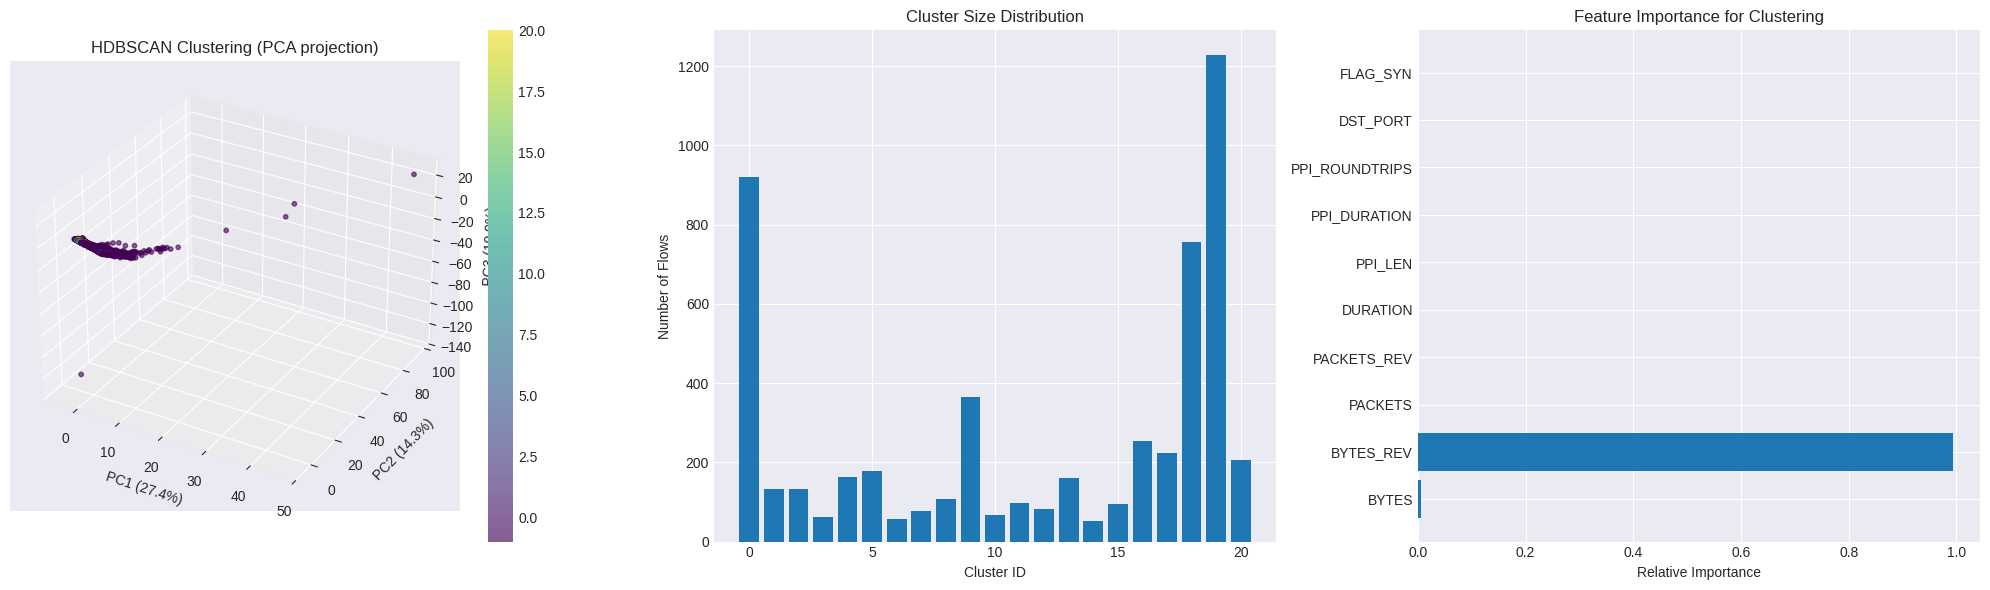

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import hdbscan

def advanced_clustering(df, sample_size=10000):
    """Perform clustering using CESNET's rich features including PPI"""
    
    print("=" * 60)
    print("ADVANCED CLUSTERING ANALYSIS")
    print("=" * 60)
    
    # Select features for clustering
    clustering_features = [
        'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV',
        'DURATION', 'PPI_LEN', 'PPI_DURATION', 'PPI_ROUNDTRIPS',
        'DST_PORT'
    ]
    
    # Add flag features
    flag_features = ['FLAG_SYN', 'FLAG_ACK', 'FLAG_PSH', 'FLAG_RST', 'FLAG_FIN']
    
    available_features = [f for f in clustering_features + flag_features if f in df.columns]
    
    if len(available_features) < 3:
        print("Insufficient features for clustering")
        return None
    
    # Sample if needed
    if len(df) > sample_size:
        print(f"Sampling {sample_size} flows for clustering...")
        df_sample = df.sample(sample_size, random_state=42)
    else:
        df_sample = df.copy()
    
    # Prepare data
    X = df_sample[available_features].fillna(0)
    
    # Feature engineering for clustering
    X_eng = X.copy()
    
    # Add derived features
    if 'BYTES' in X.columns and 'BYTES_REV' in X.columns:
        X_eng['bytes_symmetry'] = X['BYTES'] / (X['BYTES'] + X['BYTES_REV'] + 1)
    
    if 'PACKETS' in X.columns and 'DURATION' in X.columns:
        X_eng['packet_rate'] = X['PACKETS'] / (X['DURATION'] + 0.001)
    
    # Log transform
    for col in ['BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION']:
        if col in X_eng.columns:
            X_eng[f'{col}_log'] = np.log10(X_eng[col] + 1)
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_eng)
    
    # PCA for visualization
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"  PC3: {pca.explained_variance_ratio_[2]:.2%}")
    
    # HDBSCAN clustering (better for network data)
    print("\nPerforming HDBSCAN clustering...")
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=50,
        min_samples=10,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    
    clusters = clusterer.fit_predict(X_scaled)
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_outliers = (clusters == -1).sum()
    
    print(f"\nClustering Results:")
    print(f"  Clusters found: {n_clusters}")
    print(f"  Outliers: {n_outliers} ({n_outliers/len(clusters)*100:.2f}%)")
    
    df_sample['cluster'] = clusters
    
    # Analyze clusters
    print("\nCluster Profiles:")
    print("-" * 50)
    
    for cluster_id in range(n_clusters):
        cluster_data = df_sample[df_sample['cluster'] == cluster_id]
        print(f"\nCluster {cluster_id} ({len(cluster_data)} flows):")
        
        # Basic stats
        print(f"  Avg Bytes: {cluster_data['BYTES'].mean():.0f}")
        print(f"  Avg Duration: {cluster_data['DURATION'].mean():.2f}s")
        print(f"  Avg Packets: {cluster_data['PACKETS'].mean():.1f}")
        
        # Top applications
        if 'APP' in cluster_data.columns:
            top_apps = cluster_data['APP'].value_counts().head(3)
            print(f"  Top Apps: {', '.join([f'{app}({cnt})' for app, cnt in top_apps.items()])}")
        
        # Top categories
        if 'CATEGORY' in cluster_data.columns:
            top_cats = cluster_data['CATEGORY'].value_counts().head(2)
            print(f"  Categories: {', '.join(top_cats.index.tolist())}")
        
        # Check for TLS
        if 'TLS_SNI' in cluster_data.columns:
            tls_pct = cluster_data['TLS_SNI'].notna().mean() * 100
            print(f"  TLS traffic: {tls_pct:.1f}%")
    
    # Outlier analysis
    outliers = df_sample[df_sample['cluster'] == -1]
    if len(outliers) > 0:
        print(f"Outlier Analysis ({len(outliers)} flows):")
        
        if 'APP' in outliers.columns:
            print("  Top Apps in outliers:")
            for app, count in outliers['APP'].value_counts().head(5).items():
                print(f"    {app}: {count}")
        
        if 'CATEGORY' in outliers.columns:
            print("  Categories in outliers:")
            for cat, count in outliers['CATEGORY'].value_counts().head(3).items():
                print(f"    {cat}: {count}")
    
    # Visualization
    fig = plt.figure(figsize=(20, 6))
    
    # 3D scatter plot
    ax1 = fig.add_subplot(131, projection='3d')
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                         c=clusters, cmap='viridis', alpha=0.6, s=10)
    ax1.set_title('HDBSCAN Clustering (PCA projection)')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
    plt.colorbar(scatter, ax=ax1)
    
    # Cluster size distribution
    ax2 = fig.add_subplot(132)
    cluster_sizes = pd.Series(clusters[clusters != -1]).value_counts().sort_index()
    ax2.bar(cluster_sizes.index, cluster_sizes.values)
    ax2.set_xlabel('Cluster ID')
    ax2.set_ylabel('Number of Flows')
    ax2.set_title('Cluster Size Distribution')
    
    # Feature importance (based on cluster separation)
    ax3 = fig.add_subplot(133)
    feature_importance = []
    
    for i, feature in enumerate(available_features[:10]):  # Top 10 features
        feature_vals = X[feature].values
        between_cluster_var = 0
        
        for cluster_id in range(n_clusters):
            cluster_mask = clusters == cluster_id
            if cluster_mask.sum() > 0:
                cluster_mean = feature_vals[cluster_mask].mean()
                global_mean = feature_vals.mean()
                between_cluster_var += cluster_mask.sum() * (cluster_mean - global_mean) ** 2
        
        feature_importance.append(between_cluster_var / len(feature_vals))
    
    feature_importance = np.array(feature_importance)
    feature_importance = feature_importance / feature_importance.sum()
    
    ax3.barh(range(len(feature_importance)), feature_importance)
    ax3.set_yticks(range(len(feature_importance)))
    ax3.set_yticklabels(available_features[:10])
    ax3.set_xlabel('Relative Importance')
    ax3.set_title('Feature Importance for Clustering')
    
    plt.tight_layout()
    plt.show()
    
    return df_sample

clustered_df = advanced_clustering(df)

TOP IPs AND ANOMALY DETECTION
Top 20 Source IPs:
--------------------------------------------------
  251.160.54.204 : 104,538 flows ( 2.49%)
    → 1674 unique IPs,    1 unique ports, App: microsoft-onedrive
SCANNER: Contacts 1674 destinations
  220.115.70.226 :  39,304 flows ( 0.94%)
    → 2701 unique IPs,    1 unique ports, App: tiktok
SCANNER: Contacts 2701 destinations
  96.129.164.235 :  37,054 flows ( 0.88%)
    →  599 unique IPs,    1 unique ports, App: seznam-media
SCANNER: Contacts 599 destinations
  101.197.145.149:  36,786 flows ( 0.88%)
    →  932 unique IPs,    1 unique ports, App: microsoft-push
SCANNER: Contacts 932 destinations
  3.16.175.103   :  27,885 flows ( 0.66%)
    → 2307 unique IPs,    1 unique ports, App: tiktok
SCANNER: Contacts 2307 destinations
  57.143.65.161  :  25,545 flows ( 0.61%)
    → 1500 unique IPs,    1 unique ports, App: facebook-graph
SCANNER: Contacts 1500 destinations
  63.116.22.141  :  24,239 flows ( 0.58%)
    →  869 unique IPs,    1 unique

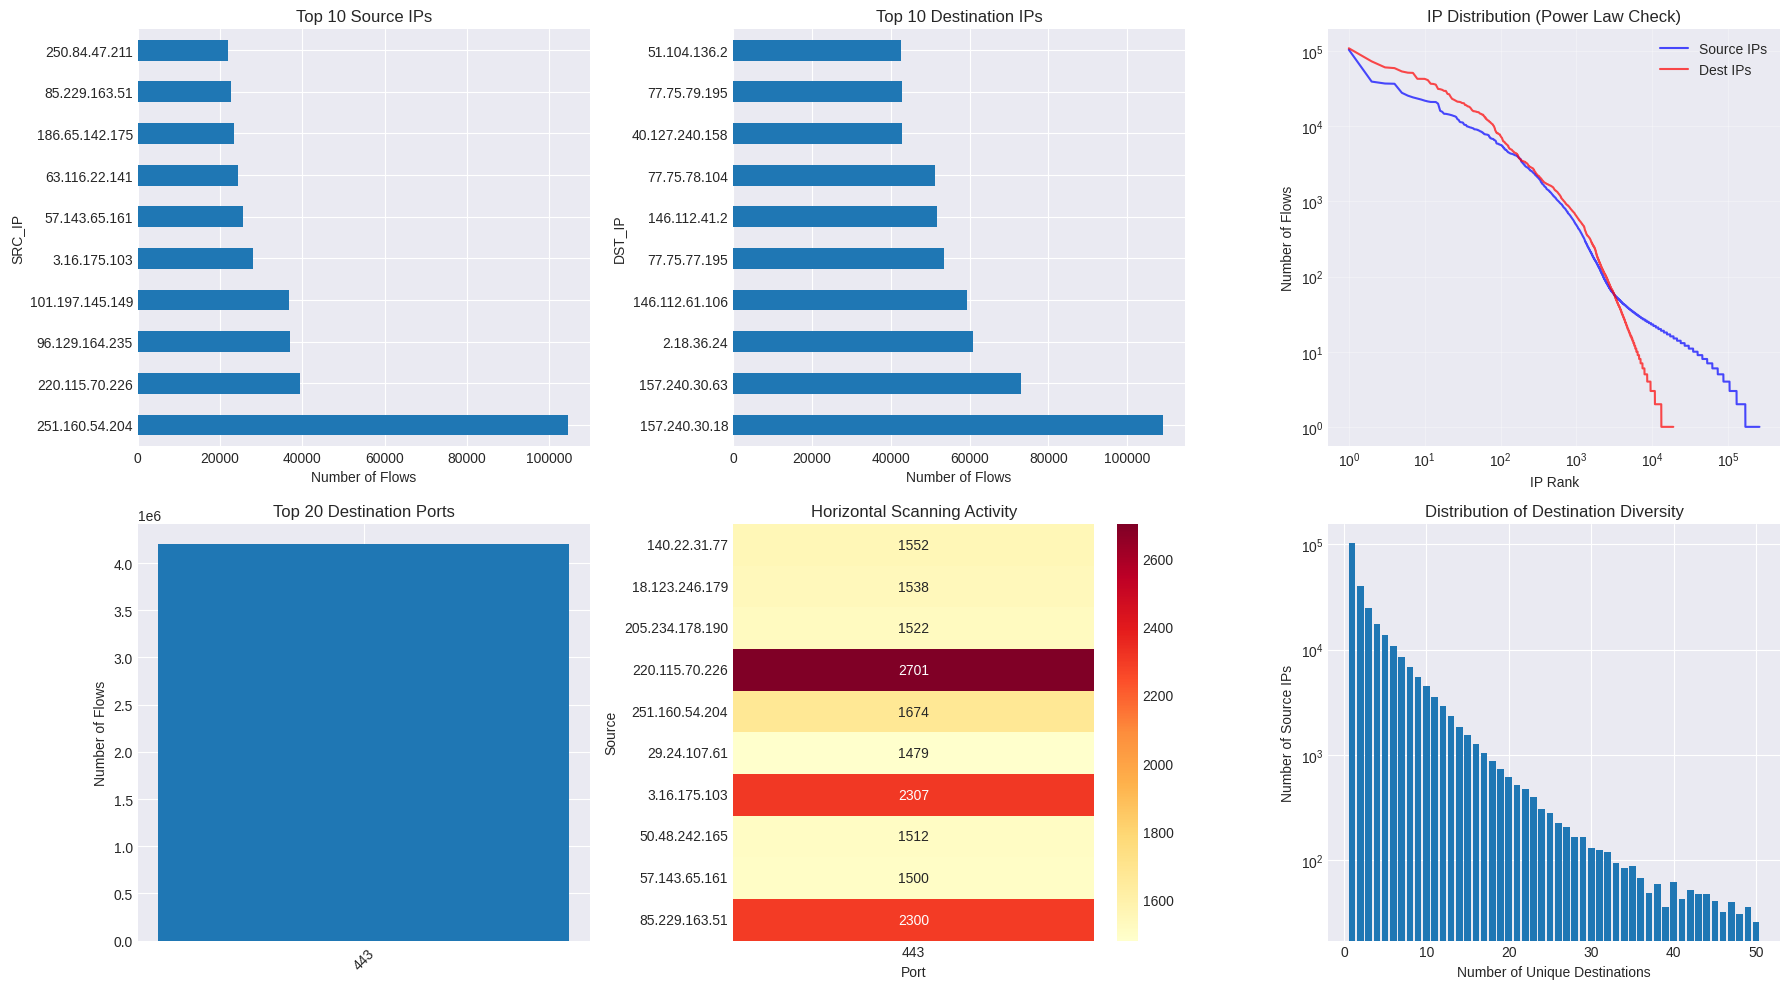

In [46]:
def analyze_top_ips(df):
    """Identify top IPs and detect scanning/DDoS patterns"""
    
    print("=" * 60)
    print("TOP IPs AND ANOMALY DETECTION")
    print("=" * 60)
    
    # Top Sources
    print("Top 20 Source IPs:")
    print("-" * 50)
    src_counts = df['SRC_IP'].value_counts().head(20)
    
    for ip, count in src_counts.items():
        pct = count / len(df) * 100
        
        # Additional analysis for each top source
        ip_data = df[df['SRC_IP'] == ip]
        unique_dst = ip_data['DST_IP'].nunique()
        unique_ports = ip_data['DST_PORT'].nunique()
        
        # Get primary app/category
        if 'APP' in ip_data.columns:
            top_app = ip_data['APP'].value_counts().head(1).index[0]
        else:
            top_app = 'N/A'
        
        print(f"  {ip:15s}: {count:7,} flows ({pct:5.2f}%)")
        print(f"    → {unique_dst:4} unique IPs, {unique_ports:4} unique ports, App: {top_app}")
        
        # Scanning detection
        if unique_dst > 100:
            print(f"SCANNER: Contacts {unique_dst} destinations")
        if unique_ports > 50:
            print(f"PORT SCANNER: Scans {unique_ports} ports")
    
    # Top Destinations
    print("\nTop 20 Destination IPs:")
    print("-" * 50)
    dst_counts = df['DST_IP'].value_counts().head(20)
    
    for ip, count in dst_counts.items():
        pct = count / len(df) * 100
        
        ip_data = df[df['DST_IP'] == ip]
        unique_src = ip_data['SRC_IP'].nunique()
        
        # Check if it's a server (port consistency)
        common_port = ip_data['DST_PORT'].value_counts().head(1)
        if not common_port.empty:
            main_port = common_port.index[0]
            port_concentration = common_port.values[0] / len(ip_data)
        else:
            main_port = 0
            port_concentration = 0
        
        print(f"  {ip:15s}: {count:7,} flows ({pct:5.2f}%)")
        print(f"    → {unique_src:4} unique sources, Main port: {main_port} ({port_concentration*100:.1f}%)")
        
        if unique_src > 1000:
            print(f"HIGH TRAFFIC: Possible DDoS target or popular server")
    
    # Advanced scanning detection
    print("\n" + "=" * 50)
    print("ADVANCED ANOMALY DETECTION")
    print("=" * 50)
    
    # Horizontal scanning (many destinations, same port)
    print("\nHorizontal Scanners (same port, many IPs):")
    horizontal_scanners = df.groupby(['SRC_IP', 'DST_PORT'])['DST_IP'].nunique()
    horizontal_scanners = horizontal_scanners[horizontal_scanners > 20].sort_values(ascending=False).head(10)
    
    for (src_ip, port), dst_count in horizontal_scanners.items():
        print(f"  {src_ip} → Port {port}: {dst_count} destinations")
    
    # Vertical scanning (same destination, many ports)
    print("\nVertical Scanners (many ports, same IP):")
    vertical_scanners = df.groupby(['SRC_IP', 'DST_IP'])['DST_PORT'].nunique()
    vertical_scanners = vertical_scanners[vertical_scanners > 10].sort_values(ascending=False).head(10)
    
    for (src_ip, dst_ip), port_count in vertical_scanners.items():
        print(f"  {src_ip} → {dst_ip}: {port_count} ports")
    
    # DDoS detection (high connection rate)
    if 'TIME_FIRST' in df.columns:
        df['minute'] = pd.to_datetime(df['TIME_FIRST']).dt.floor('T')
        
        # Connections per minute per destination
        minute_dst_counts = df.groupby(['minute', 'DST_IP']).size()
        high_rate = minute_dst_counts[minute_dst_counts > 100].sort_values(ascending=False)
        
        if len(high_rate) > 0:
            print("High-rate targets (>100 flows/minute):")
            
            # Group by destination to find sustained attacks
            for dst_ip in high_rate.index.get_level_values('DST_IP').unique()[:5]:
                dst_rates = high_rate[high_rate.index.get_level_values('DST_IP') == dst_ip]
                max_rate = dst_rates.max()
                duration = len(dst_rates)
                print(f"  {dst_ip}: Max {max_rate} flows/min, Duration: {duration} minutes")
    
    # IP diversity metrics
    print("\nNetwork Diversity Metrics:")
    print("-" * 50)
    
    total_flows = len(df)
    unique_src = df['SRC_IP'].nunique()
    unique_dst = df['DST_IP'].nunique()
    
    src_entropy = stats.entropy(df['SRC_IP'].value_counts())
    dst_entropy = stats.entropy(df['DST_IP'].value_counts())
    
    print(f"  Unique source IPs: {unique_src:,}")
    print(f"  Unique destination IPs: {unique_dst:,}")
    print(f"  Source entropy: {src_entropy:.3f}")
    print(f"  Destination entropy: {dst_entropy:.3f}")
    print(f"  Avg flows per source: {total_flows/unique_src:.2f}")
    print(f"  Avg flows per destination: {total_flows/unique_dst:.2f}")
    
    if src_entropy < 3:
        print("Low source entropy - traffic concentration detected")
    if dst_entropy < 3:
        print("Low destination entropy - possible targeted activity")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Top sources
    src_counts.head(10).plot(kind='barh', ax=axes[0, 0])
    axes[0, 0].set_title('Top 10 Source IPs')
    axes[0, 0].set_xlabel('Number of Flows')
    
    # Top destinations
    dst_counts.head(10).plot(kind='barh', ax=axes[0, 1])
    axes[0, 1].set_title('Top 10 Destination IPs')
    axes[0, 1].set_xlabel('Number of Flows')
    
    # IP distribution (log-log plot)
    src_freq = df['SRC_IP'].value_counts().values
    axes[0, 2].loglog(range(1, len(src_freq)+1), sorted(src_freq, reverse=True), 'b-', alpha=0.7, label='Source IPs')
    
    dst_freq = df['DST_IP'].value_counts().values
    axes[0, 2].loglog(range(1, len(dst_freq)+1), sorted(dst_freq, reverse=True), 'r-', alpha=0.7, label='Dest IPs')
    
    axes[0, 2].set_xlabel('IP Rank')
    axes[0, 2].set_ylabel('Number of Flows')
    axes[0, 2].set_title('IP Distribution (Power Law Check)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Port distribution
    port_counts = df['DST_PORT'].value_counts().head(20)
    axes[1, 0].bar(range(len(port_counts)), port_counts.values)
    axes[1, 0].set_xticks(range(len(port_counts)))
    axes[1, 0].set_xticklabels([str(p) for p in port_counts.index], rotation=45)
    axes[1, 0].set_ylabel('Number of Flows')
    axes[1, 0].set_title('Top 20 Destination Ports')
    
    # Scanning activity heatmap
    if len(horizontal_scanners) > 0:
        scan_data = []
        for (src_ip, port), dst_count in horizontal_scanners.head(10).items():
            scan_data.append([src_ip, port, dst_count])
        
        if scan_data:
            scan_df = pd.DataFrame(scan_data, columns=['Source', 'Port', 'Targets'])
            scan_pivot = scan_df.pivot_table(index='Source', columns='Port', values='Targets', fill_value=0)
            
            sns.heatmap(scan_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1, 1])
            axes[1, 1].set_title('Horizontal Scanning Activity')
    
    # Unique destinations per source
    dst_per_src = df.groupby('SRC_IP')['DST_IP'].nunique().value_counts().sort_index()
    axes[1, 2].bar(dst_per_src.index[:50], dst_per_src.values[:50])
    axes[1, 2].set_xlabel('Number of Unique Destinations')
    axes[1, 2].set_ylabel('Number of Source IPs')
    axes[1, 2].set_title('Distribution of Destination Diversity')
    axes[1, 2].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    return src_counts, dst_counts

src_ips, dst_ips = analyze_top_ips(df)

CONNECTION ANALYSIS & CORRELATIONS
Connection Duration Analysis:
--------------------------------------------------
  quick(<1s)     : 1,379,986 (32.83%)
  short(<10s)    :  895,144 (21.30%)
  medium(<1m)    :  868,087 (20.65%)
  long(<5m)      :  529,956 (12.61%)
  flash(<100ms)  :  434,046 (10.33%)
  extended(<1h)  :   95,645 ( 2.28%)
  instant(<1ms)  :        0 ( 0.00%)
  persistent(>1h):        0 ( 0.00%)

Anomalous Connection Patterns:
  Flash crowds (duration<0.1s, packets>100): 8,326
    Top apps: {'o2tv': 3086, 'bing': 937, 'tiktok': 870}

Feature Correlation Analysis:
--------------------------------------------------
Strongly Correlated Features (|r| > 0.7):
  PACKETS_REV     ↔ PPI_LEN        : +0.937
  PACKETS         ↔ PPI_LEN        : +0.915
  PACKETS         ↔ PACKETS_REV    : +0.903
  BYTES           ↔ PACKETS        : +0.809
  BYTES           ↔ PPI_LEN        : +0.793
  BYTES_REV       ↔ PACKETS_REV    : +0.767
  BYTES_REV       ↔ PPI_LEN        : +0.746
  BYTES        

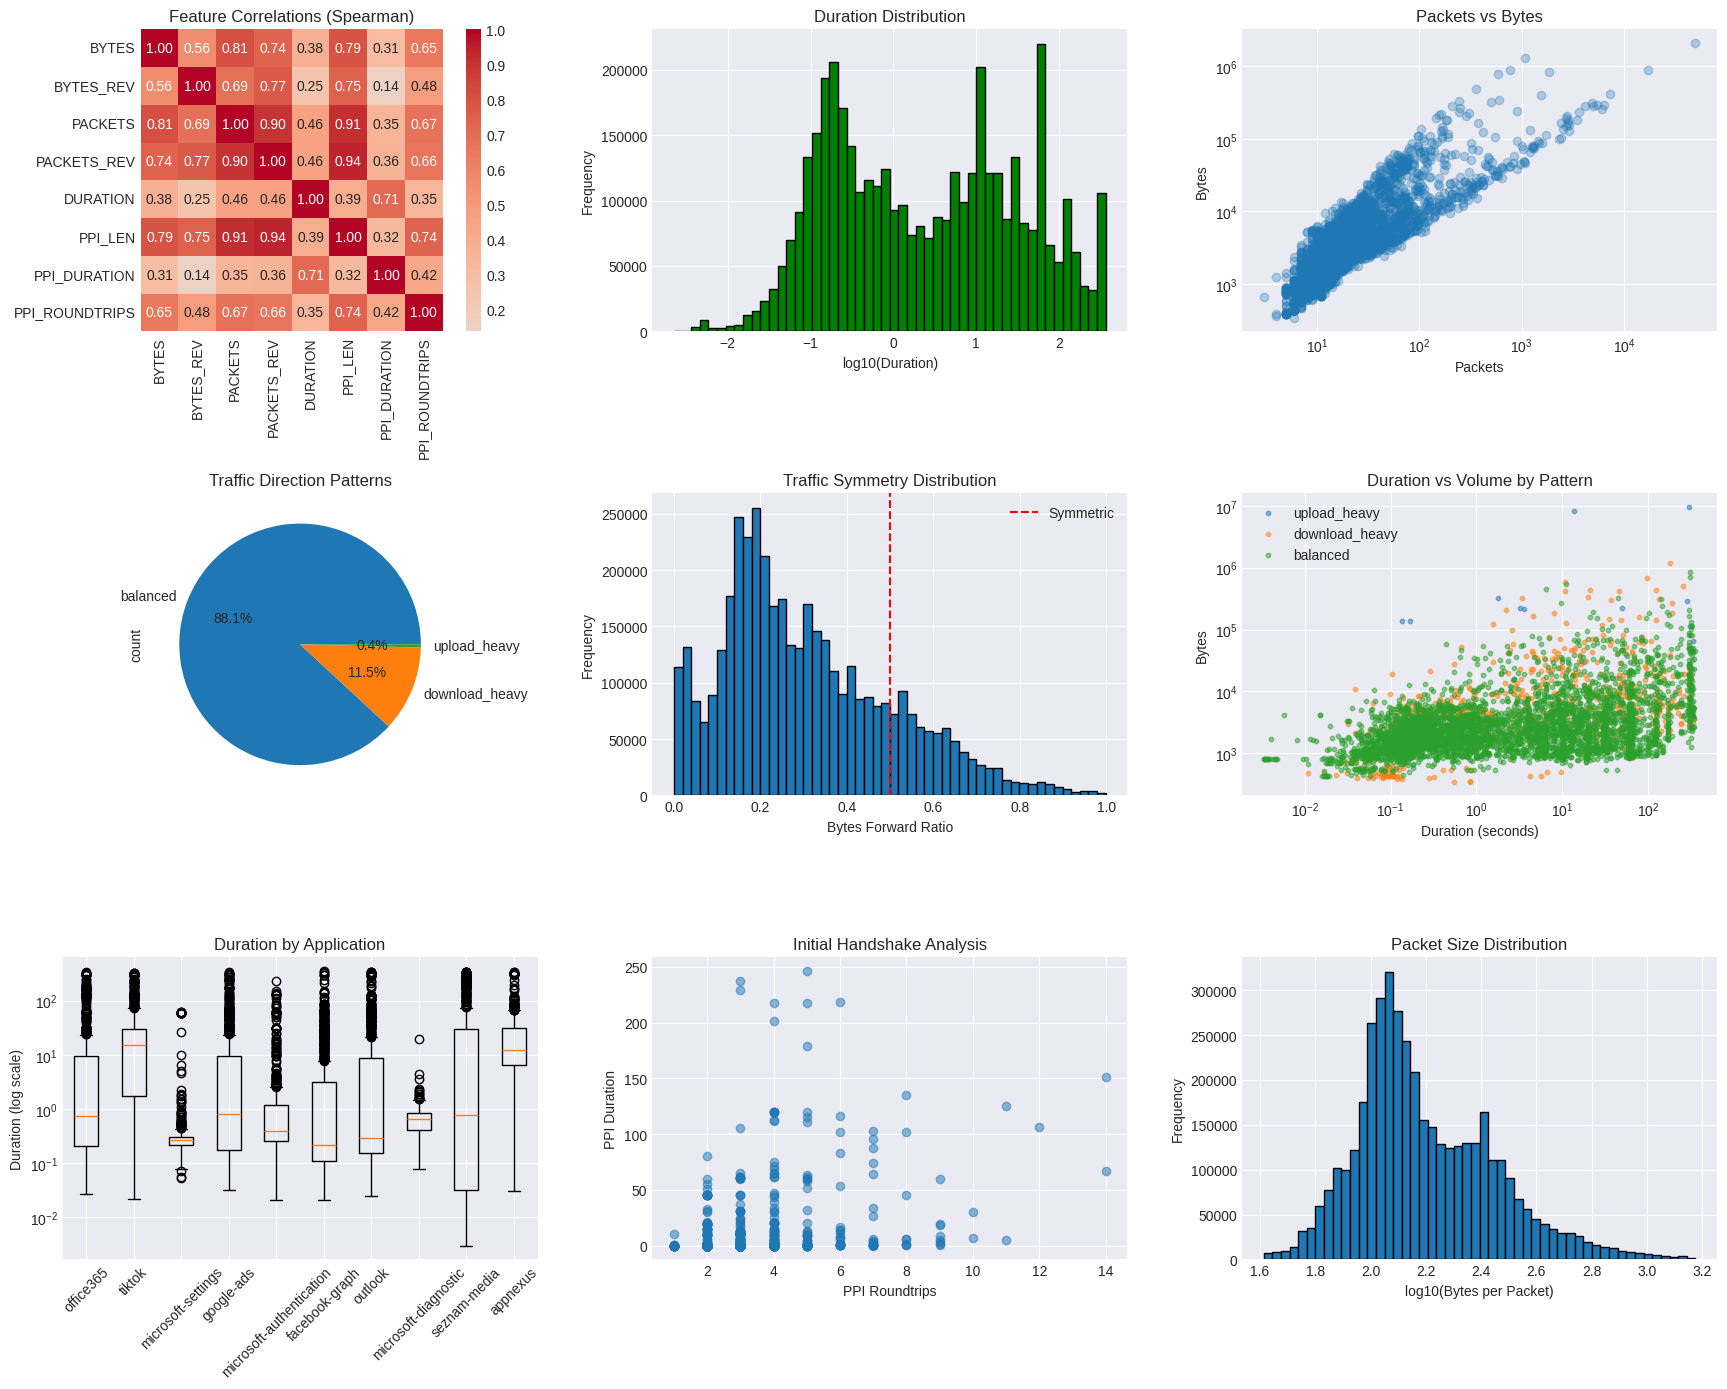

In [47]:
def connection_correlation_analysis(df):
    """Analyze connection characteristics and feature correlations"""
    
    print("=" * 60)
    print("CONNECTION ANALYSIS & CORRELATIONS")
    print("=" * 60)
    
    # Duration Analysis
    print("Connection Duration Analysis:")
    print("-" * 50)
    
    # Duration categories
    df['duration_category'] = pd.cut(
        df['DURATION'],
        bins=[0, 0.001, 0.1, 1, 10, 60, 300, 3600, np.inf],
        labels=['instant(<1ms)', 'flash(<100ms)', 'quick(<1s)', 'short(<10s)', 
               'medium(<1m)', 'long(<5m)', 'extended(<1h)', 'persistent(>1h)']
    )
    
    duration_dist = df['duration_category'].value_counts()
    
    for category, count in duration_dist.items():
        pct = count / len(df) * 100
        print(f"  {category:15s}: {count:8,} ({pct:5.2f}%)")
    
    # Analyze anomalous patterns
    print("\nAnomalous Connection Patterns:")
    
    # Flash crowds (very short, high volume)
    flash_crowds = df[
        (df['DURATION'] < 0.1) & 
        ((df['PACKETS'] + df['PACKETS_REV']) > 100)
    ]
    
    if len(flash_crowds) > 0:
        print(f"  Flash crowds (duration<0.1s, packets>100): {len(flash_crowds):,}")
        if 'APP' in flash_crowds.columns:
            print(f"    Top apps: {flash_crowds['APP'].value_counts().head(3).to_dict()}")
    
    # Persistent connections
    persistent = df[df['DURATION'] > 3600]
    if len(persistent) > 0:
        print(f"  Persistent (>1h): {len(persistent):,}")
        if 'APP' in persistent.columns:
            print(f"    Top apps: {persistent['APP'].value_counts().head(3).to_dict()}")
    
    # Correlation Analysis
    print("\nFeature Correlation Analysis:")
    print("-" * 50)
    
    # Select features for correlation
    corr_features = [
        'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV',
        'DURATION', 'PPI_LEN', 'PPI_DURATION', 'PPI_ROUNDTRIPS'
    ]
    
    available_corr_features = [f for f in corr_features if f in df.columns]
    
    if len(available_corr_features) > 2:
        # Calculate correlations
        corr_matrix = df[available_corr_features].corr(method='spearman')
        
        # Find strong correlations
        strong_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    strong_corr.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_val
                    ))
        
        print("Strongly Correlated Features (|r| > 0.7):")
        for f1, f2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {f1:15s} ↔ {f2:15s}: {corr:+.3f}")
    
    # Traffic symmetry analysis
    print("\nTraffic Symmetry Analysis:")
    print("-" * 50)
    
    df['bytes_ratio'] = df['BYTES'] / (df['BYTES'] + df['BYTES_REV'] + 1)
    df['packets_ratio'] = df['PACKETS'] / (df['PACKETS'] + df['PACKETS_REV'] + 1)
    
    print(f"Bytes Ratio (forward/total):")
    print(f"  Mean: {df['bytes_ratio'].mean():.3f}")
    print(f"  Std: {df['bytes_ratio'].std():.3f}")
    
    # Categorize traffic patterns
    df['traffic_pattern'] = 'balanced'
    df.loc[df['bytes_ratio'] > 0.9, 'traffic_pattern'] = 'upload_heavy'
    df.loc[df['bytes_ratio'] < 0.1, 'traffic_pattern'] = 'download_heavy'
    
    pattern_dist = df['traffic_pattern'].value_counts()
    print(f"\nTraffic Patterns:")
    for pattern, count in pattern_dist.items():
        pct = count / len(df) * 100
        print(f"  {pattern:15s}: {count:8,} ({pct:5.2f}%)")
    
    # PPI Analysis (Packet Payload Inspection)
    if 'PPI_LEN' in df.columns:
        print("\nPPI (Initial Packets) Analysis:")
        print("-" * 50)
        
        ppi_coverage = (df['PPI_LEN'] > 0).sum()
        print(f"  Flows with PPI data: {ppi_coverage:,} ({ppi_coverage/len(df)*100:.2f}%)")
        
        if ppi_coverage > 0:
            ppi_flows = df[df['PPI_LEN'] > 0]
            print(f"  Avg PPI length: {ppi_flows['PPI_LEN'].mean():.1f} bytes")
            print(f"  Avg PPI duration: {ppi_flows['PPI_DURATION'].mean():.3f} seconds")
            print(f"  Avg roundtrips: {ppi_flows['PPI_ROUNDTRIPS'].mean():.1f}")
    
    # Visualization
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    
    # Correlation heatmap
    if len(available_corr_features) > 2:
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                   center=0, square=True, ax=axes[0, 0])
        axes[0, 0].set_title('Feature Correlations (Spearman)')
    
    # Duration distribution
    duration_log = np.log10(df['DURATION'][df['DURATION'] > 0] + 0.001)
    axes[0, 1].hist(duration_log, bins=50, edgecolor='black', color='green')
    axes[0, 1].set_xlabel('log10(Duration)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Duration Distribution')
    
    # Bytes vs Packets
    sample = df.sample(min(5000, len(df)))
    axes[0, 2].scatter(sample['PACKETS'], sample['BYTES'], alpha=0.3)
    axes[0, 2].set_xlabel('Packets')
    axes[0, 2].set_ylabel('Bytes')
    axes[0, 2].set_title('Packets vs Bytes')
    axes[0, 2].set_xscale('log')
    axes[0, 2].set_yscale('log')
    
    # Traffic pattern distribution
    pattern_dist.plot(kind='pie', autopct='%1.1f%%', ax=axes[1, 0])
    axes[1, 0].set_title('Traffic Direction Patterns')
    
    # Bytes ratio distribution
    axes[1, 1].hist(df['bytes_ratio'], bins=50, edgecolor='black')
    axes[1, 1].set_xlabel('Bytes Forward Ratio')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Traffic Symmetry Distribution')
    axes[1, 1].axvline(0.5, color='r', linestyle='--', label='Symmetric')
    axes[1, 1].legend()
    
    # Duration vs Bytes colored by pattern
    sample = df.sample(min(5000, len(df)))
    for pattern in ['upload_heavy', 'download_heavy', 'balanced']:
        pattern_data = sample[sample['traffic_pattern'] == pattern]
        if len(pattern_data) > 0:
            axes[1, 2].scatter(pattern_data['DURATION'], pattern_data['BYTES'],
                             alpha=0.5, label=pattern, s=10)
    
    axes[1, 2].set_xlabel('Duration (seconds)')
    axes[1, 2].set_ylabel('Bytes')
    axes[1, 2].set_title('Duration vs Volume by Pattern')
    axes[1, 2].set_xscale('log')
    axes[1, 2].set_yscale('log')
    axes[1, 2].legend()
    
    # Application duration boxplot
    if 'APP' in df.columns:
        top_apps = df['APP'].value_counts().head(10).index
        app_durations = [df[df['APP'] == app]['DURATION'].values[:1000] for app in top_apps]
        
        axes[2, 0].boxplot(app_durations, labels=top_apps)
        axes[2, 0].set_yscale('log')
        axes[2, 0].set_ylabel('Duration (log scale)')
        axes[2, 0].set_title('Duration by Application')
        axes[2, 0].tick_params(axis='x', rotation=45)
    
    # PPI analysis
    if 'PPI_ROUNDTRIPS' in df.columns:
        ppi_flows = df[df['PPI_ROUNDTRIPS'] > 0]
        if len(ppi_flows) > 0:
            axes[2, 1].scatter(ppi_flows['PPI_ROUNDTRIPS'][:1000], 
                             ppi_flows['PPI_DURATION'][:1000], alpha=0.5)
            axes[2, 1].set_xlabel('PPI Roundtrips')
            axes[2, 1].set_ylabel('PPI Duration')
            axes[2, 1].set_title('Initial Handshake Analysis')
    
    # Bytes per packet analysis
    df['bytes_per_packet'] = df['BYTES'] / (df['PACKETS'] + 1)
    axes[2, 2].hist(np.log10(df['bytes_per_packet'][df['bytes_per_packet'] > 0] + 1),
                   bins=50, edgecolor='black')
    axes[2, 2].set_xlabel('log10(Bytes per Packet)')
    axes[2, 2].set_ylabel('Frequency')
    axes[2, 2].set_title('Packet Size Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return df

df = connection_correlation_analysis(df)

In [49]:
def analyze_packet_histograms(df):
    """Analyze packet size and inter-packet time histograms"""
    
    print("=" * 60)
    print("PACKET HISTOGRAM ANALYSIS (CESNET UNIQUE FEATURE)")
    print("=" * 60)
    
    # Parse histogram fields
    hist_fields = ['PHIST_SRC_SIZES', 'PHIST_DST_SIZES', 
                  'PHIST_SRC_IPT', 'PHIST_DST_IPT']
    
    for field in hist_fields:
        if field in df.columns:
            print(f"\nAnalyzing {field}:")
            
            # Check coverage
            coverage = df[field].notna().sum()
            print(f"  Coverage: {coverage:,} flows ({coverage/len(df)*100:.2f}%)")
            
            if coverage > 0:
                # Sample analysis (histograms are complex structures)
                sample_hist = df[df[field].notna()][field].iloc[0]
                print(f"  Sample histogram: {str(sample_hist)[:100]}...")
    
    # For flows with histograms, analyze patterns
    if 'PHIST_SRC_SIZES' in df.columns:
        hist_flows = df[df['PHIST_SRC_SIZES'].notna()]
        
        if len(hist_flows) > 0:
            print("\nFlows with packet histograms:")
            print(f"  Total: {len(hist_flows):,}")
            
            # Analyze by application
            if 'APP' in hist_flows.columns:
                print("\n  Top apps with histogram data:")
                for app, count in hist_flows['APP'].value_counts().head(10).items():
                    print(f"    {app}: {count:,}")
    
    print("Packet histograms enable:")
    print("ML models to learn from packet size distributions")
    print("Detection of protocol tunneling")
    print("Fingerprinting of encrypted applications")
    print("Timing-based side-channel analysis")

analyze_packet_histograms(df)

PACKET HISTOGRAM ANALYSIS (CESNET UNIQUE FEATURE)

Analyzing PHIST_SRC_SIZES:
  Coverage: 4,202,864 flows (100.00%)
  Sample histogram: [1, 0, 0, 0, 1, 0, 0, 0]...

Analyzing PHIST_DST_SIZES:
  Coverage: 4,202,864 flows (100.00%)
  Sample histogram: [0, 0, 0, 0, 0, 0, 1, 3]...

Analyzing PHIST_SRC_IPT:
  Coverage: 4,202,864 flows (100.00%)
  Sample histogram: [0, 1, 0, 0, 0, 0, 0, 0]...

Analyzing PHIST_DST_IPT:
  Coverage: 4,202,864 flows (100.00%)
  Sample histogram: [3, 0, 0, 0, 0, 0, 0, 0]...

Flows with packet histograms:
  Total: 4,202,864

  Top apps with histogram data:
    office365: 195,811
    tiktok: 183,100
    microsoft-settings: 131,735
    google-ads: 131,621
    microsoft-authentication: 121,874
    facebook-graph: 117,883
    outlook: 117,808
    microsoft-diagnostic: 105,800
    seznam-media: 103,612
    appnexus: 103,247
Packet histograms enable:
ML models to learn from packet size distributions
Detection of protocol tunneling
Fingerprinting of encrypted application

ASN (AUTONOMOUS SYSTEM) ANALYSIS
Top 20 Destination ASNs:
--------------------------------------------------
  AS  8075 (Microsoft      ): 816,341 (19.42%)
  AS 15169 (Google         ): 655,922 (15.61%)
  AS 32934 (Facebook/Meta  ): 364,714 ( 8.68%)
  AS 43037 (Unknown        ): 340,715 ( 8.11%)
  AS 16625 (Unknown        ): 300,436 ( 7.15%)
  AS 20940 (Akamai         ): 258,873 ( 6.16%)
  AS  8068 (Unknown        ): 195,422 ( 4.65%)
  AS 14618 (Unknown        ): 157,189 ( 3.74%)
  AS 16509 (Amazon AWS     ): 125,743 ( 2.99%)
  AS 36692 (Unknown        ): 111,916 ( 2.66%)
  AS 29990 (Unknown        ):  96,938 ( 2.31%)
  AS  2852 (Unknown        ):  84,958 ( 2.02%)
  AS 26667 (Unknown        ):  71,770 ( 1.71%)
  AS  3766 (Unknown        ):  65,048 ( 1.55%)
  AS 13335 (Cloudflare     ):  59,937 ( 1.43%)
  AS  5610 (Unknown        ):  47,526 ( 1.13%)
  AS 13414 (Unknown        ):  45,697 ( 1.09%)
  AS 62713 (Unknown        ):  42,504 ( 1.01%)
  AS 60068 (Unknown        ):  32,590 ( 0.78%

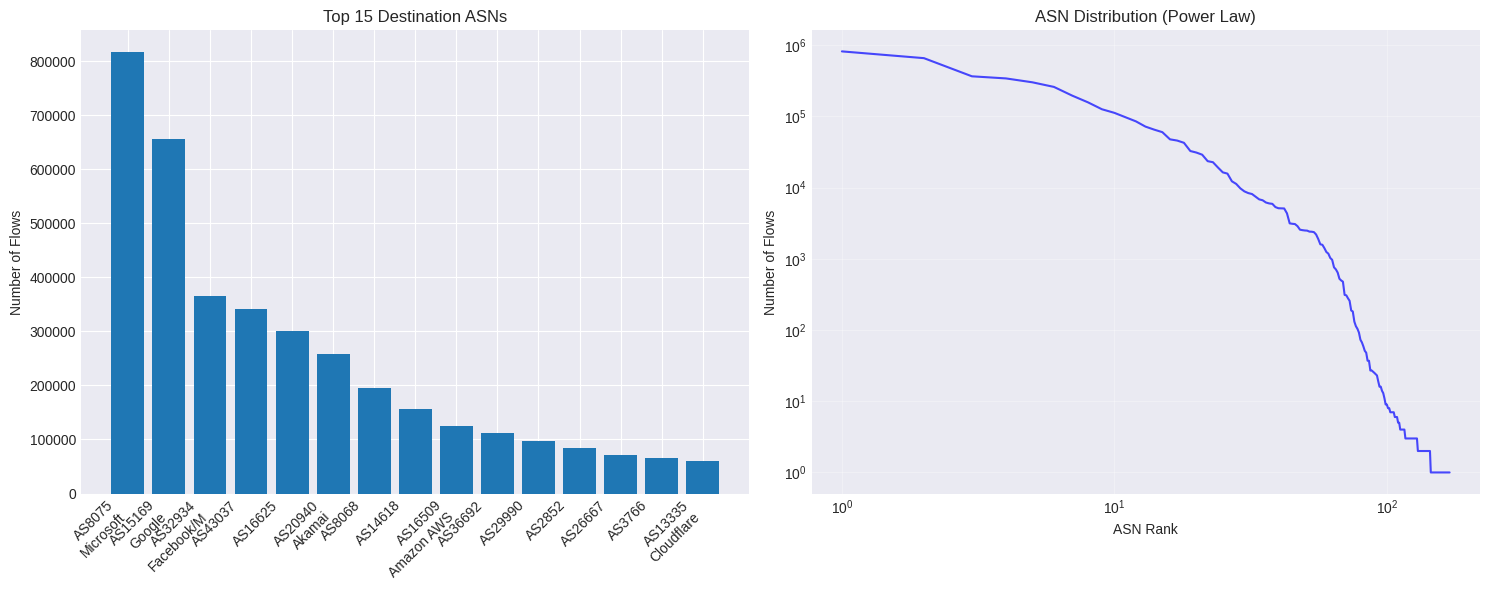

In [50]:
def analyze_asn_geographic(df):
    """Analyze Autonomous System Numbers for geographic/organizational patterns"""
    
    print("=" * 60)
    print("ASN (AUTONOMOUS SYSTEM) ANALYSIS")
    print("=" * 60)
    
    if 'DST_ASN' in df.columns:
        # ASN distribution
        asn_counts = df['DST_ASN'].value_counts().head(20)
        
        # Common ASN mappings (examples)
        asn_names = {
            15169: 'Google',
            32934: 'Facebook/Meta', 
            16509: 'Amazon AWS',
            8075: 'Microsoft',
            13335: 'Cloudflare',
            20940: 'Akamai',
            16276: 'OVH',
            24940: 'Hetzner'
        }
        
        print("Top 20 Destination ASNs:")
        print("-" * 50)
        
        for asn, count in asn_counts.items():
            pct = count / len(df) * 100
            name = asn_names.get(asn, 'Unknown')
            print(f"  AS{asn:6d} ({name:15s}): {count:7,} ({pct:5.2f}%)")
        
        # Analyze traffic by ASN
        print("\nTraffic Distribution by Major Providers:")
        
        major_asns = {
            'Cloud (AWS/Azure/GCP)': [16509, 8075, 15169],
            'CDN (Cloudflare/Akamai)': [13335, 20940],
            'Social Media': [32934],  # Facebook/Meta
        }
        
        for category, asn_list in major_asns.items():
            traffic = df[df['DST_ASN'].isin(asn_list)]
            if len(traffic) > 0:
                pct = len(traffic) / len(df) * 100
                bytes_total = (traffic['BYTES'] + traffic['BYTES_REV']).sum()
                print(f"  {category:25s}: {len(traffic):7,} flows ({pct:5.2f}%), {bytes_total/1024**3:.2f} GB")
        
        # ASN diversity
        unique_asns = df['DST_ASN'].nunique()
        asn_entropy = stats.entropy(df['DST_ASN'].value_counts())
        
        print(f"\nASN Diversity Metrics:")
        print(f"  Unique ASNs: {unique_asns:,}")
        print(f"  ASN entropy: {asn_entropy:.3f}")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Top ASNs bar chart
        top_asns = asn_counts.head(15)
        asn_labels = [f"AS{asn}\n{asn_names.get(asn, '')[:10]}" for asn in top_asns.index]
        
        axes[0].bar(range(len(top_asns)), top_asns.values)
        axes[0].set_xticks(range(len(top_asns)))
        axes[0].set_xticklabels(asn_labels, rotation=45, ha='right')
        axes[0].set_ylabel('Number of Flows')
        axes[0].set_title('Top 15 Destination ASNs')
        
        # ASN distribution (log-log)
        asn_freq = df['DST_ASN'].value_counts().values
        axes[1].loglog(range(1, len(asn_freq)+1), sorted(asn_freq, reverse=True), 'b-', alpha=0.7)
        axes[1].set_xlabel('ASN Rank')
        axes[1].set_ylabel('Number of Flows')
        axes[1].set_title('ASN Distribution (Power Law)')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

analyze_asn_geographic(df)